<a href="https://colab.research.google.com/github/R-Kav/Similarity-Based-Scheduling-Algorithm/blob/main/Pharma_Sales_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pharma-sales-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F466126%2F875246%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240809%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240809T140748Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3715d9e427685768f79dff1841a119dab3dd6e267726e4a913afb3b1dd5e1aac2c08340357e3b2d41529647afe18365f2e171ff97378c18ca7fdbd74b30de75feff577a3996fe5d74e408c2ed9f7dfb8e91d270f46c9c642387bc240c3b2bd53873c30f9726e05717a11b941002496fafe1cd5a3a80b0e3bef35222480ac3decf996881d14056579aae4e376eaf648a9b1a79f8bafab3895fd4129b828351cdbc35ae865c7fca7f31d95deaedf6460128728bb11fb4be5b3dca364c122cdd3f4e925df7c54af4317fdbd61fa3644295f51c455c9f67f46335187a0f574413ee04df4e4b8752e487428656d4874d82537e33aba3ad592d9be19ab99b7cce1b13a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 360706 bytes downloaded
Downloaded and uncompressed: pharma-sales-data
Data source import complete.


# İlaç Satış Rakamlarının Aylara Göre İncelenmesi ve Geleceğe Yönelik Tahminler

## Giriş
1950'li yıllarda Yapay Zeka kavramı ortaya çıktığından beri, veri bizim için çok önemli bir konuma geldi. Çünkü Yapay Zeka dediğimiz bu kavram verinin genelleştirilmiş bir gösterimini yapmaktadır. Yapay Sinir Ağlarının popülerleşmesiyle beraber, veri çok daha önemli bir konuma geldi çünkü bu yapılar tam bir veri canavarıdırlar. Biz bu projemizde Yapay Sinir Ağlarına pek girmeyeceğiz fakat bugünlere bizi getiren temeli burada göstermek istedik.

Bu projemizde 2014-2019 yılları arasındaki ilaç satış rakamlarını barındıran bir verisetini öncelikle genel hatlarıyla inceleyeceğiz, temizleyeceğiz ve sonrasında bu tutarlı veriyi görselleştirme yoluyla yorumlayacağız. Tüm bunlardan sonra ise Makina Öğrenmesi yöntemleri aracılığı ile bu veriden bir takım modeller çıkartıp, bu modeller ile geleceğe yönelik tahminlerde bulunacağız ve bu tahminleri yorumlayacağız.

![shutterstock_1226220355.jpg](attachment:096d5ca1-782a-4673-8226-e5455eb88684.jpg)

## İçerik

1. [Python Kütüphaneleri](#1)
2. [Veri İçeriği](#2)
3. [Veriyi Okuma ve Genel Bir Analiz](#3)
4. [Veri Analizinin Aylara ve Yılları Göre yapılabilmesi Amaçlı Sütunların Düzenlenmesi](#4)
5. [Verinin Ayrıntılı incelenmesi ve Analizi](#5)

<a id='1' ></a>
## Python Kütüphaneleri

Bu bölümde, bu proje boyunca kullanılacak olan python kütüphaneleri ve veriseti içe aktarılmıştır.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pharma-sales-data/saleshourly.csv
/kaggle/input/pharma-sales-data/salesdaily.csv
/kaggle/input/pharma-sales-data/salesweekly.csv
/kaggle/input/pharma-sales-data/salesmonthly.csv


<a id='2' ></a>
## Veri İçeriği

* Veride toplam 600.000 adet satış ağı mevcut olup, 6 yıllık periyotları kapsamaktadır. Verisetinde toplamda 57 çeşit ilaç mevcuttur. BU ilaçlar Anatomik ve Terapotik Kimyasal Sınıflandırma sistemi ile 8 kategoride toplanmıştır.

Bu kategoriler ise:

* M01AB: İnflamasyonu ve ödemi azaltan (Anti-inflammatory), hastalığın ilerlemesini yavaşlatan (antirheumatic), ağrı kesici / ateş düşürücü (Non Steroidal Antienflamatuar İlaçlar) ve Asetik Asit türevi ilaçlar.
* M01AE: İnflamasyonu ve ödemi azaltan (Anti-inflammatory), hastalığın ilerlemesini yavaşlatan (antirheumatic), ağrı kesici / ateş düşürücü (Non Steroidal Antienflamatuar İlaçlar) ve Propiyonik Asit türevi ilaçlar.
* N02BA: Analjezikler ve ateş düşürücü, salisilik asit ve türevleri.
* N02BE/B: Analjezikler ve ateş düşürücü, Pirazolonlar ve Anilidler.
* N05B: Psikoleptik ilaçlar, Anksiyolitik ilaçlar
* N05C - Psikoleptik ilaçlar, Hipnotikler ve yatıştırıcı ilaçlar.
* R03 - Obstrüktif hava yolu hastalıkları için ilaçlar.
* R06 - Sistemik kullanım için antihistaminikler ilaçlar.

Bu verisetinde bu ilaç gruplarına yönelik aylık satış rakamları mevcuttur. Bu satış rakamlarına göre önce incelemeler yapılıcaktır sonrasında ise gelecek aylara yönelik tahminlerde bulunabilecek Makina Öğrenmesi modelleri geliştirilecektir.

<a id='3' ></a>
## Veriyi Okuma ve Genel Bir Analiz

* Öncelikle veri setimizi içeriye aktarıp genel bir incelemesi yaparak, veriyi temizlememize gerek var mı? sorusuna cevap arayacağız.

In [3]:
df_monthly = pd.read_csv("/kaggle/input/pharma-sales-data/salesmonthly.csv")
df_monthly.head(5)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


* Yukarıda görüldüğü üzere, verisetimiz içerisinde 8 farklı ilaç kategorisine ait aylık satışlar ve satış tarihleri mevcuttur.

In [4]:
df_monthly.describe()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,149.992000,116.514286,115.020843,892.542071,262.118571,17.842857,167.675000,86.662571
std,31.485325,27.889336,31.245899,338.843908,85.060930,8.481242,81.767979,45.859336
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,137.490000,103.518250,94.375000,648.187500,223.750000,12.000000,112.000000,49.875000
50%,154.635000,114.840000,117.225000,865.824500,250.300000,18.000000,160.000000,74.100000
75%,169.000000,128.359750,133.837500,1061.580000,293.650000,23.000000,218.250000,119.807500
max,211.130000,222.351000,191.600000,1856.815000,492.000000,50.000000,386.000000,213.040000


* Yukarıdaki tabloda verimizin basit olacak bir şekilde istatistiksel durumunu görüyoruz. Burada dikkat etmemiz gereken kısım ise;
* İlk olarak sınıfların, ortalama değerleri ise %50 değerlerinin birbirine yakın olması gerekir. Bunun sebebi ise çarpıklık durumundan kaçınmak istememizdir. Bu çarpıklığa sebep olan durum ise outlier dediğimiz verilerdir. İyi bir analiz ve model eğitimi için bunlardan kurtulmamız gerekir. Bizim verimizin tablosuna baktığımıda ise genel olarak sağlıklı olduğunu söyleyebiliriz. Fakat temizlememiz gereken bir miktar veri var gibi durmaktadır. Örnek olarak ise NO2BE ve R06 verilebilir.

In [5]:
# information about data
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   datum   70 non-null     object 
 1   M01AB   70 non-null     float64
 2   M01AE   70 non-null     float64
 3   N02BA   70 non-null     float64
 4   N02BE   70 non-null     float64
 5   N05B    70 non-null     float64
 6   N05C    70 non-null     float64
 7   R03     70 non-null     float64
 8   R06     70 non-null     float64
dtypes: float64(8), object(1)
memory usage: 5.0+ KB


* Basit bir şekilde vesetimize ait bilgi tablosunu incelediğimizde herhangi bir sıkıntılı veri görememekteyiz. Çünkü her hücre veri ile doldurulmuştur bir şekilde görülmektedir. Fakat bir ihtimal olarak boş hücreler 0 değeri ile doldurulmuş olabilir, bu sebep ile onu kontrol etmemiz gerekecek. Ayrıca veri setimizde bulunan verilerin tipleri de float cinsinde olup, tam da beklediğimiz şekildedir.

In [6]:
# Sıfır değerli satırlar var ise bunları atmamız gerekiyor.
for col in df_monthly.columns:
    df_monthly = df_monthly[df_monthly[col] != 0]
df_monthly = df_monthly.reset_index(drop=True)

In [7]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   datum   69 non-null     object 
 1   M01AB   69 non-null     float64
 2   M01AE   69 non-null     float64
 3   N02BA   69 non-null     float64
 4   N02BE   69 non-null     float64
 5   N05B    69 non-null     float64
 6   N05C    69 non-null     float64
 7   R03     69 non-null     float64
 8   R06     69 non-null     float64
dtypes: float64(8), object(1)
memory usage: 5.0+ KB


In [8]:
df_monthly.describe()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,152.165797,118.202899,116.687812,905.477464,265.902899,18.101449,170.105072,87.918551
std,25.889420,24.222290,28.165372,323.448143,79.526993,8.260724,79.780194,44.966193
min,44.370000,37.300000,20.650000,295.150000,86.000000,5.000000,37.000000,11.130000
25%,137.640000,103.522000,97.000000,649.800000,226.000000,12.000000,112.000000,51.000000
50%,154.750000,114.961000,117.750000,867.899000,250.600000,18.000000,161.000000,74.500000
75%,169.320000,128.402000,133.850000,1062.686000,295.200000,23.000000,219.000000,120.800000
max,211.130000,222.351000,191.600000,1856.815000,492.000000,50.000000,386.000000,213.040000


* Yukarıda bir kod parçası aracılığı ile sıfırlardan oluşan hatalı satırları verisetinden atma işlemi yaptık bu işlem sonucunda 1 satırın gerçekten hatalı olduğunu saptık ve verimizi daha sağlıklı hale getirdik, bu sayede eğiteceğimiz model daha iyi sonuçlar verecektir.

<a id='4' ></a>
### Veri Analizinin Aylara ve Yılları Göre yapılabilmesi Amaçlı Sütunların Düzenlenmesi

* Öncelikle bizim için bu proje özelinde gerekli olan kategorilerin başında yıl ve ay bilgileri gelmektedir. Bu verisetinde istediğimiz bu bilgiler tek bir sütun (datum) içinde verilmektedirler. Bu durum analiz açısında ve kodlama açısından zorluk çıkartacağı için biz bu kategoriyi ay ve yıl olmak üzere iki sütuna bölüyoruz.

In [9]:
# Ayları, daha anlamlı bir şekilde analiz yapabilmek adına direkt olarak string tipinde yeni bir sütun olarak verisetimize kazandırdık.
aylar = ["Ocak", "Şubat", "Mart", "Nisan", "Mayıs", "Haziran", "Temmuz", "Ağustos", "Eylül", "Ekim", "Kasım", "Aralık"]
df_monthly["Ay"] = 0
df_monthly["Yıl"] = "0"
for i, satir in enumerate(df_monthly["datum"]):
    df_monthly["Ay"][i] = aylar[int(satir.split("-")[1]) - 1]
    df_monthly["Yıl"][i] = str(satir.split("-")[0])
df_monthly.head()

<ipython-input-9-bc01ba9621d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly["Ay"][i] = aylar[int(satir.split("-")[1]) - 1]
<ipython-input-9-bc01ba9621d8>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Ocak' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_monthly["Ay"][i] = aylar[int(satir.split("-")[1]) - 1]
<ipython-input-9-bc01ba9621d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly["Yıl"][i] = str(satir.split("-")[0])
<ipython-input-9-bc01ba9621d8>:7: SettingWithCopyWarnin

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Ay,Yıl
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2,Ocak,2014
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2,Şubat,2014
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4,Mart,2014
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7,Nisan,2014
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7,Mayıs,2014


* Artık ayları yeni bir sütun olarak aldığım için bu proje kapsamında ihtiyacım olmayan datum bilgisini veriden atıyoruz.

In [10]:
df_monthly.drop(["datum"], inplace=True, axis=1)
df_monthly.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Ay,Yıl
0,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2,Ocak,2014
1,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2,Şubat,2014
2,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4,Mart,2014
3,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7,Nisan,2014
4,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7,Mayıs,2014


<a id='5' ></a>
## Aykırı Değer Kontrolü

* Bu kısımda model eğitimi ve veri analizi için çok önem taşıyon bir durum olan aykırı değerleri kontrol edeceğiz. Bu değerler bizim için önemli çünkü verilerin sağlıklı analizi ve modellerin tahminleme durumlarını fazlaca baltalayabilmektedirler.

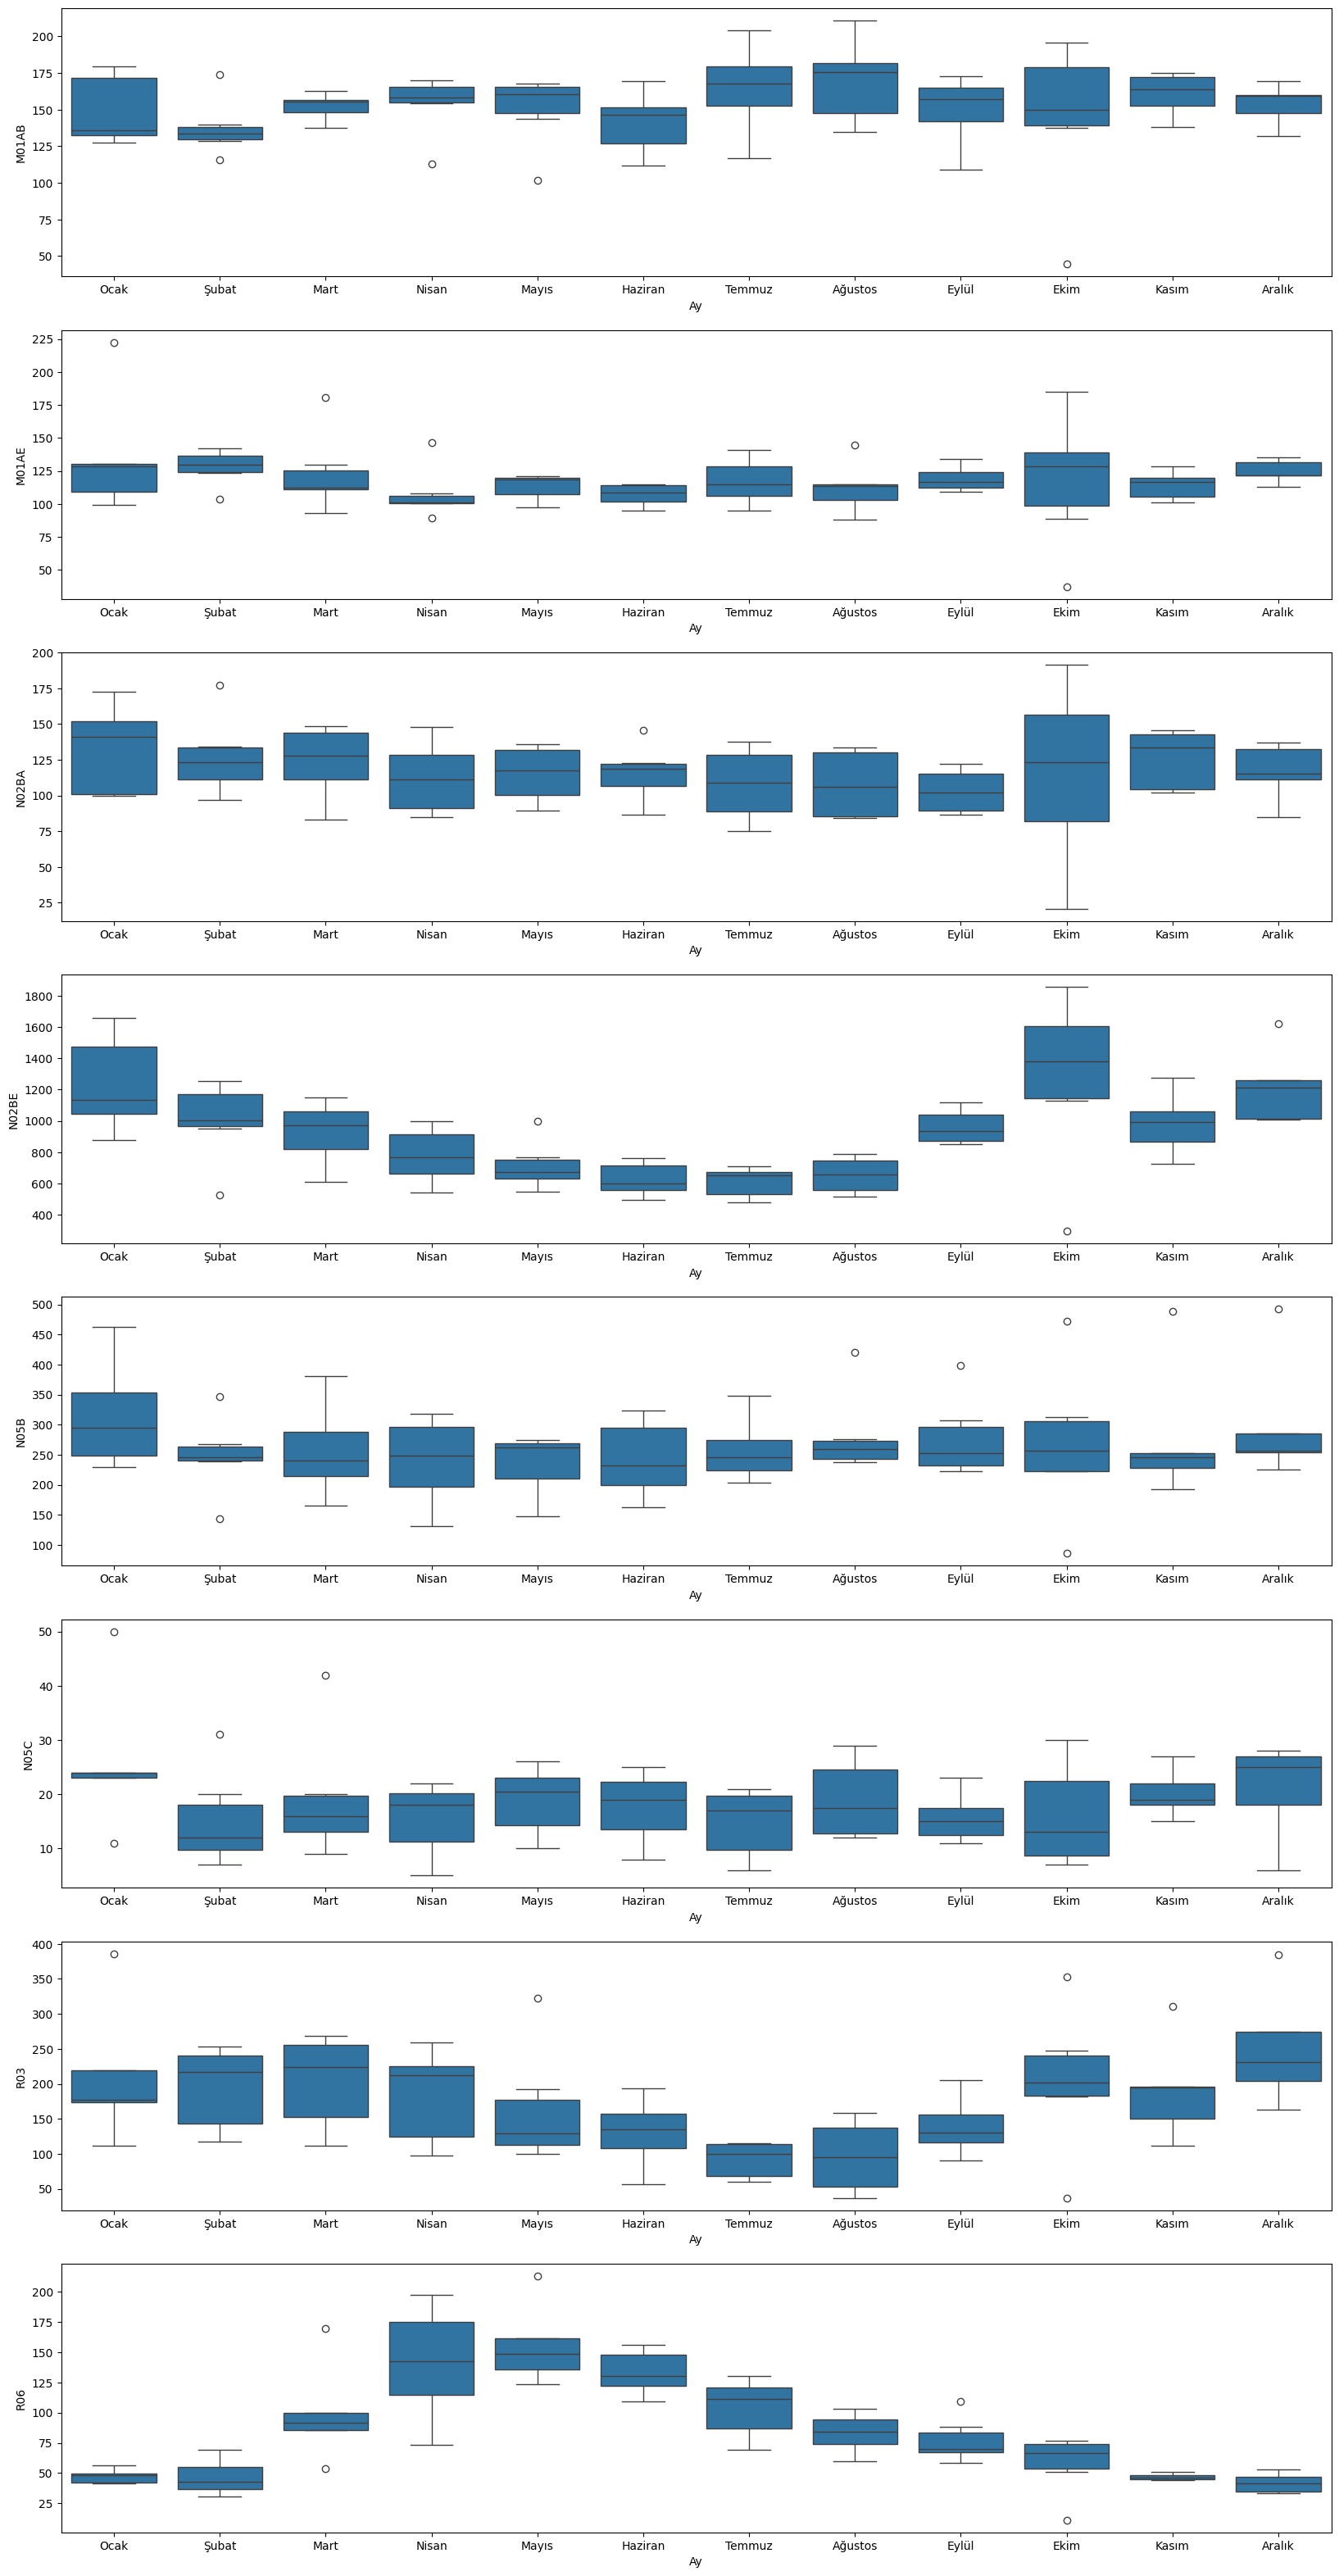

In [11]:
# Verimizi aykırı değer analizi yapmak için çizdiriyoruz.
fig, axes = plt.subplots(8, 1, figsize=(20, 40))
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=df_monthly, x="Ay", y=name, ax=ax)

* Yukarıdaki aylara göre ilaç satış rakamları incelendiğinde nokta şeklinde gözükmekte olan aykırı değerler göze çarpmaktadır. Bu değelerin bir kısmının atılması gerekiyor.
* Ayrıca ön bilgi olarak grafikten gözümüze çarpan ise, bu verinin büyük oranda analie ve model eğitimine uygun olduğudur.

In [12]:
# Aykırı değerlerimizi bir tablo şeklinde çekip inceleyeceğiz.
def detect_outliers(df, features):
    outlier_indices = []

    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # outlier step
        outlier_step = IQR * 2.75
        # detect outlier and their indices
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indices
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items())

    return multiple_outliers

In [13]:
kategoriler = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
df_monthly.loc[detect_outliers(df_monthly,kategoriler)]

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Ay,Yıl
68,44.37,37.300,20.650,295.150,86.0,7.0,37.0,11.13,Ekim,2019
59,179.70,222.351,99.700,1660.612,295.2,23.0,386.0,41.30,Ocak,2019
10,138.08,100.860,142.700,723.800,489.0,19.0,112.0,45.20,Kasım,2014
11,131.90,121.401,111.124,1015.660,492.0,25.0,163.0,33.40,Aralık,2014


In [14]:
# bulunan aykırı değerleri veri setimizden atılacaktır.
df_monthly = df_monthly.drop(detect_outliers(df_monthly,kategoriler),axis=0).reset_index(drop=True)

* Aykırı değelerin veriden atılması bizim için çok önemli bir unsur olmasına karşın burada bir artı eksi durumu mevcut çünkü elimizde entry bazında veri sayısı az durumda ve bu verilerin her biri bizim için çok önemli yani kolay kolay onlardan vazgeçemeyiz. BU sebep ile analizde ve modelde çok ciddi sıkıntı yaratabilecek aykırı değerleri verimizden attık.

<a id='5' ></a>
## Verinin Ayrıntılı incelenmesi ve Analizi

* Bu bölümde, ay bazında ilaç satış rakamlarının yıllara göre analizinin yapılmasını kolaylaştırma amaçlı olarak bir takım veri görselleştirme tekniklerinden yararlanılmış. Relplot isimli numerik analiz taraflı ilişkisel çizim yapmakta olan teknikten yararlanılmış ve yıllar ise soluktan koyu tonlara doğru geçmişten günümüze doğru yılların (2014-2019) temsili yapılmıştır.
* Ayrıca veri analizinde çok önemli bir yer kaplayan korelasyon grafiğinden de yararlanılmıştır. Bu grafik bizim için kategoriler arasında bulunan ikili ilişkiler noktasında önemli bilgiler içerir. Bu bilgiler ile bize farklı kategoriler arasındaki satış hacimlerindeki yakınlıklardan ya da uzaklıklar hakkında yorumlamalar yapmaya kolaylık sağlar. Ayrıca bu verisetinin model eğitime ne tahmin yapma durumuna yatkınlığı hakkında da bize fazlaca bilgi vermektedir.

### Yıllara Göre M01AB İlaç kategorisinin Ay Bazında Satış Rakamları

* **M01AB ilaç Sınıfı:** İnflamasyonu ve ödemi azaltan (Anti-inflammatory), hastalığın ilerlemesini yavaşlatan (antirheumatic), ağrı kesici / ateş düşürücü (Non Steroidal Antienflamatuar İlaçlar) ve Asetik Asit türevi ilaçlar.

* Bu ilaç türü daha çok yaralanma ve iltihaplanmaya karşı kullanılmaktadır. Ayrıca oluşmuş olan ağrıları daha hafif semptomlarla geçirme sürecini ve süresini azaltan tedavilerde kullanılar.

<ipython-input-15-61c48a974cb5>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(kind='line', data=df_monthly, x='Ay', y='M01AB', palette="flare", aspect=3)


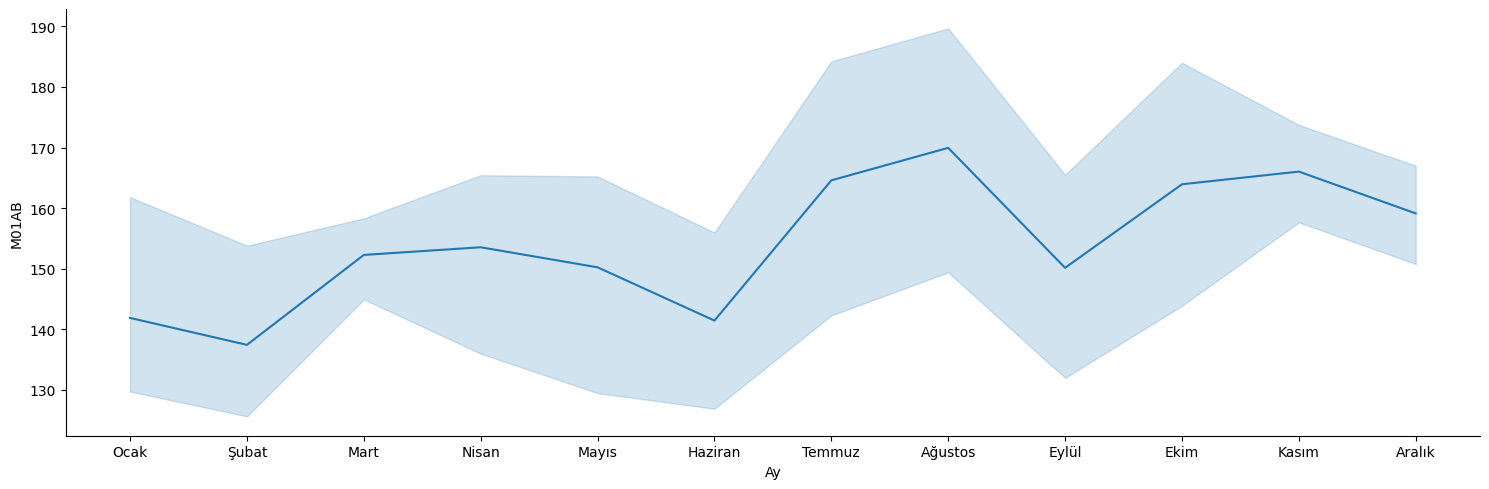

In [15]:
sns.relplot(kind='line', data=df_monthly, x='Ay', y='M01AB', palette="flare", aspect=3)

* Grafiği genel olarak incelediğimiz takdirde yaz aylarında satış rakamlarında diğer aylara göre bir artış gözlemlenmiştir. Bunun sebepleri ise aşağıda yorumlanmıştır;

 * Havaların ısınmasıyla birlikte insanların doğada ve açık ortamlarda hava sıcaklığından dolayı korunma giysileri bulunmadan aktivede bulunma şansının artması ile birlikte yaralanmalarda büyük bir artış gözlenmektedir.   
 * Yıllara göre satış incelendiği takdirde mevsimsel olarak değişimler benzer şekilde dalgalanmaktadır.

### Yıllara Göre M01AE İlaç Kategorisinin Ay Bazında Satış Rakamları

* **M01AE:** İnflamasyonu ve ödemi azaltan (Anti-inflammatory), hastalığın ilerlemesini yavaşlatan (antirheumatic), ağrı kesici / ateş düşürücü (Non Steroidal Antienflamatuar İlaçlar) ve Propiyonik Asit türevi ilaçlar.

* Ağrı kesici, ateş düşürücü ve yangı önleyici veya giderici etkileri olan narkotik olmayan ağrı kesici ilaçların bir grubu.

Kaynak: https://nedir.ileilgili.org/propiyonik+asit+t%C3%BCrevleri

<ipython-input-16-6a8af27eeb00>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(kind='line', data=df_monthly, x='Ay', y='M01AE', palette="flare", aspect=3)


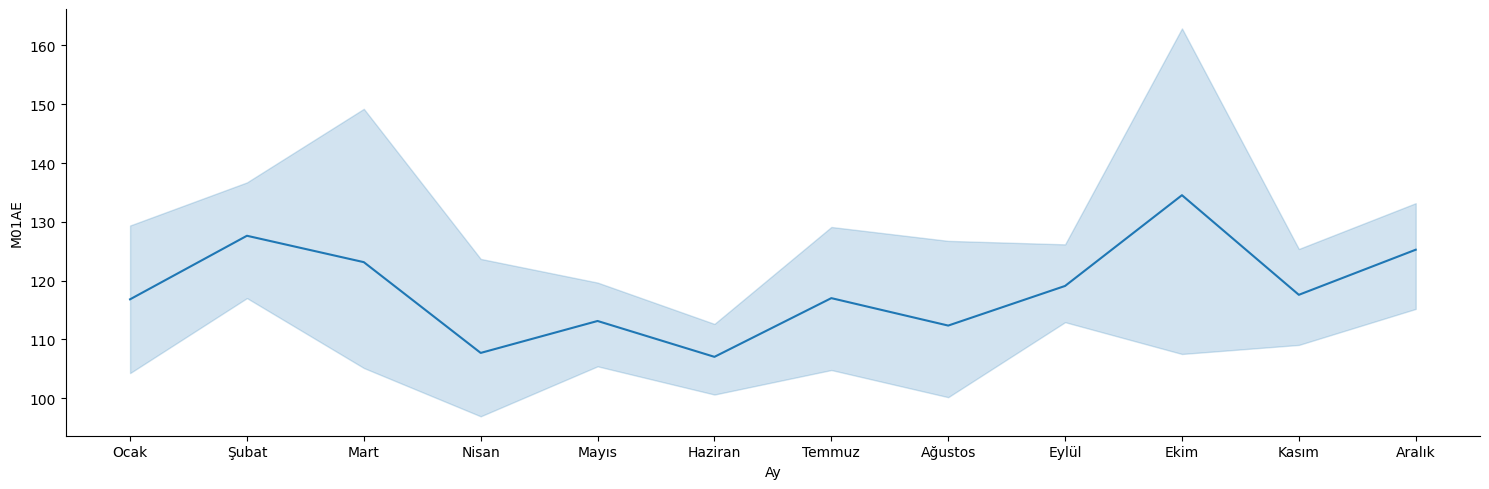

In [16]:
sns.relplot(kind='line', data=df_monthly, x='Ay', y='M01AE', palette="flare", aspect=3)

* Grafiği genel olarak incelediğimiz takdirde, bu ilaç türü daha mevsimsel geçiş süreçlerinde kullanılan ilaç kategorisinde bulunmaktadır. Bu ilaç grubu daha çok, ateş düşürücü, soğuk algınlığı ve ağrı kesici olarak kullanılan ilaç türlerini içerdiğinden dolayı daha soğuk geçen aylarda satış miktarlarında bir artış gözlemlenmektedir.

### Yıllara Göre N02BA İlaç Kategorisinin Ay Bazında Satış Rakamları

* **N02BA:** Analjezik ve ateş düşürücü olarak kullanılan salisilik asit ve türevi ilaçlardır.

* Analjezik ya da ağrı kesici ağrıyı dindirmek ve analjeziye (acı yitimine) yol açmak için kullanılan her türlü ilaca verilen isimdir.

* Analjezik ilaçlar periferik ve merkezi sinir sistemine etki eder. Geçici olarak etkileyen ve bazı durumlarda duyumu tamamen ortadan kaldıran anesteziklerden farklıdırlar.

Kaynakça: https://tr.wikipedia.org/wiki/A%C4%9Fr%C4%B1_kesici

<ipython-input-17-93a1bcba5fb3>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(kind='line', data=df_monthly, x='Ay', y='N02BA', palette="flare", aspect=3)


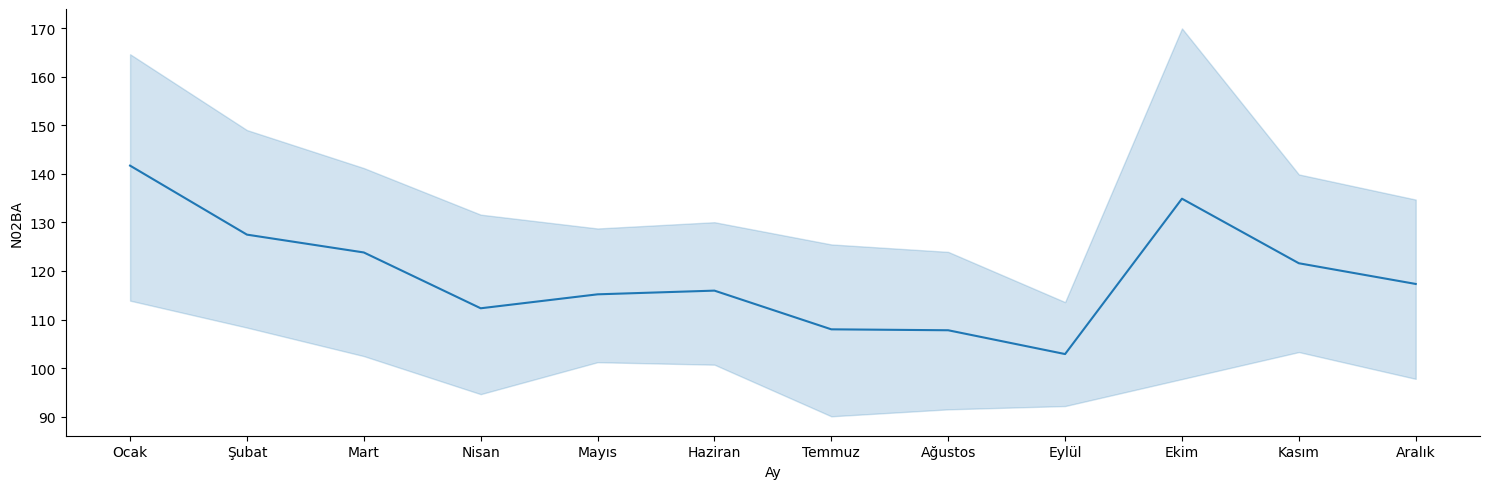

In [17]:
sns.relplot(kind='line', data=df_monthly, x='Ay', y='N02BA', palette="flare", aspect=3)

* Grafiği genel olarak incelediğimi takdirde M01AE ilaç grubu ile benzerlik göstermektedir. Bunun sebebini yorumlamak gerekir ise:
 * Bu iki ilaç grubu ortak semptom gösteren sorunlara karşı izlenilen benzer çözüm yolları sundukları için satış rakamları da benzer bir çizelge izlemektedir.

### Yıllara Göre N02BE İlaç Kategorisinin Ay Bazında Satış Rakamları

* **N02BE/B:** Analjezikler ve ateş düşürücü, Pirazolonlar ve Anilidler.

* Asprin ve Novalgin tipi reçetesiz, hafif seyreden geçici sorunlar için kullanılan ilaç grubudur.

* Bir örnek olarak; Metamizol (ya da genel adıyla Novalgin® veya Novaljin®; veteriner preparatlarda sıklıkla Novamizol®), sık kullanılan ve reçetesiz satılabilen, ağrı kesici ve ateş düşürücü bir ilaçtır. Genellikle metamizol sodyum tuzu şeklinde uygulanır. Metamizol analjezik, spazmolitik, antiromatizmal ve antipiretik etkilerinin yanı sıra yangılı bölgede damar geçirgenliğini azaltmak süretiyle bölgedeki eksudasyonun azalmasını ve sıvı içeriğin hızla emilmesini sağladığı için antienflamatuvar etkisi de vardır.

Kaynakça: https://tr.wikipedia.org/wiki/Metamizol

<ipython-input-18-24a51a9cb5c1>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(kind='line', data=df_monthly, x='Ay', y='N02BE', palette="flare", aspect=3)


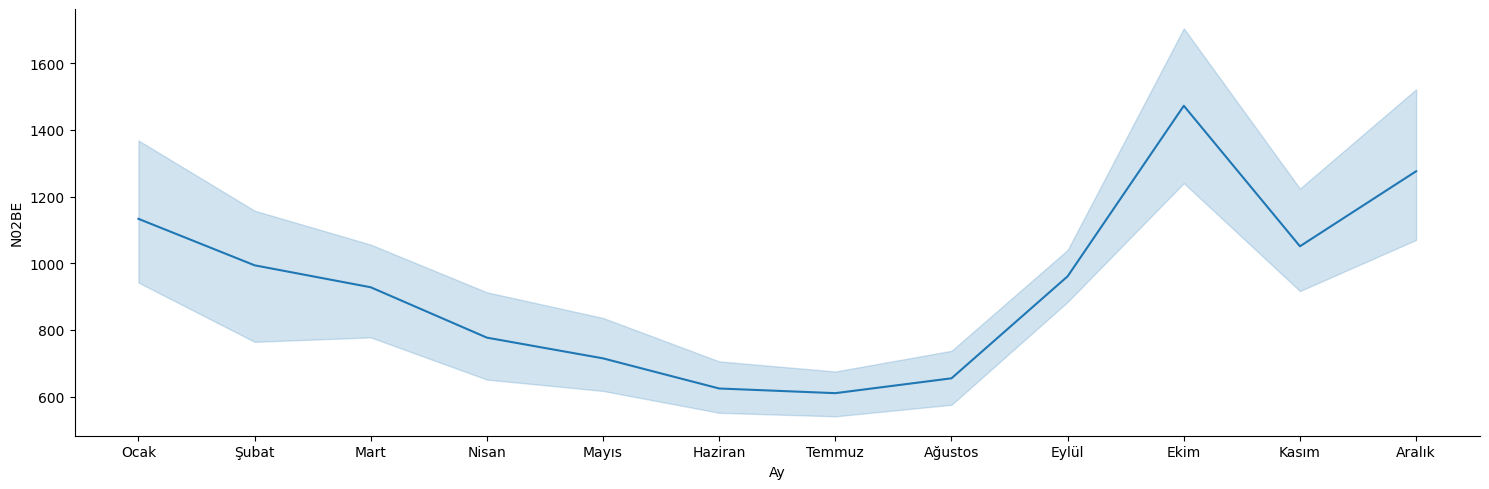

In [18]:
sns.relplot(kind='line', data=df_monthly, x='Ay', y='N02BE', palette="flare", aspect=3)

* Bu ilaç grubu yine M01AB ve N02BA ilaç grupları ile benzer sorunlara yönelik çözüm içermektedir. Çizelgede görüldüğü üzere sonbahar ve kış mevsimlerinde diğer mevsimlere göre ciddi bir artış gözlemlenmektedir.

### Yıllara Göre N05B İlaç Kategorisinin Ay Bazında Satış Rakamları

* **N05B:** Psikoleptik, Anksiyolitik ilaçlar.

* Antipsikotik ya da nöroleptik ilaçlar başta şizofreni olmak üzere psikozların tedavisinde kullanılan ilaçlardır.Temelde psikotik belirtilerle giden ruhsal ve organik hastalıkların sağaltımında kullanılan moleküllerdir. Sınıfın ilk temsilcisi klorpromazinin bulunuşu psikiyatride önemli bir kilometre taşı olup, önemli sayıda kronik psikiyatri hastasının hastaneler dışında veya evde bakımlarını olanaklı hale getirmiştir. İlk nöroleptik 1950 yılında tesadüfen etkisi fark edilen klorpromazindir. Daha sonraki 55 yıl boyunca birçok nöroleptik sentezlenmiştir.Başlıca kullanım alanları; Antipsikotikler şizofreni ve bipolar bozukluklar başta olmak üzere psikotik belirtilerin görüldüğü deliryum, psikotik depresyon gibi diğer durumlarda da tercih edilirler.

Kaynakça: https://tr.wikipedia.org/wiki/Antipsikotik

<ipython-input-19-6117a684bf0f>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(kind='line', data=df_monthly, x='Ay', y='N05B', palette="flare", aspect=3)


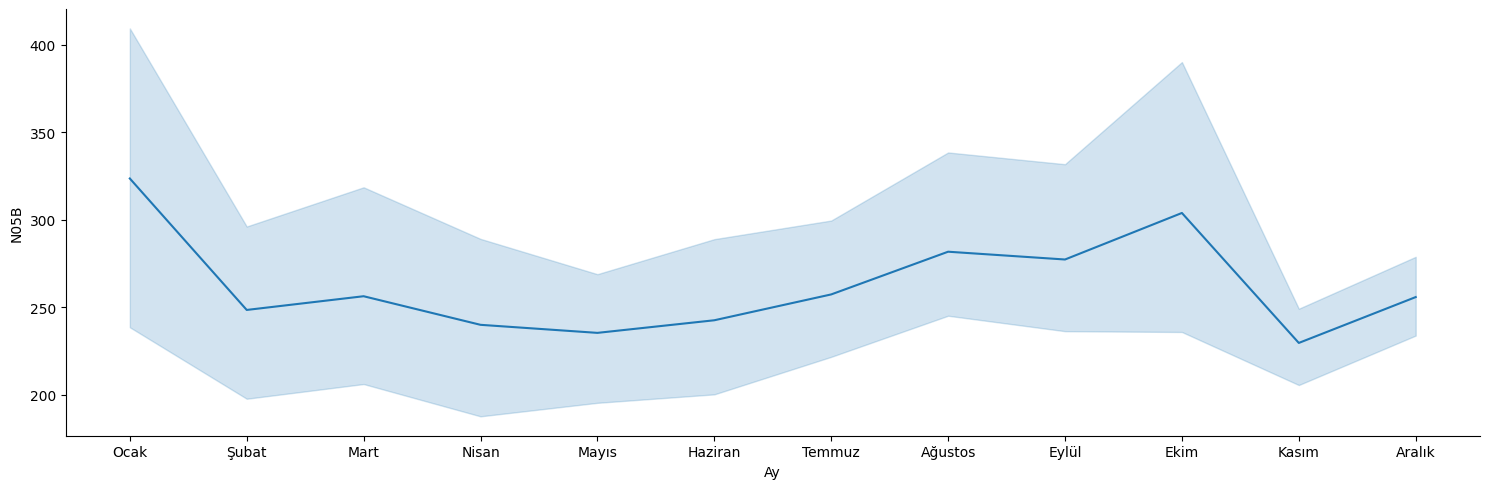

In [19]:
sns.relplot(kind='line', data=df_monthly, x='Ay', y='N05B', palette="flare", aspect=3)

* Bu ilaç grubu günümüzde süre gelen çeşitli birçok sebepten yani yaşamın her evresinde karşımıza çıkan sorunlarla alakalı sıkıntılar sebepli psikolojik sorunların semptomlarını azaltmaya yönelik kullanılan tedavi yöntemlerini içeren ilaç grubudur. Bu sebep ile ayların satışları etkisi bu grafik bazında görülememiştir.

### Yıllara Göre N05C İlaç Kategorisinin Ay Bazında Satış Rakamları
* **N05C:** - Psikoleptik, Hipnotikler ve yatıştırıcı ilaçlar.

* Anksiyete psikiyatride en sık karşılaşılan sorunlardandır. Kaygı olarak da isimlendirilen anksiyetenin özgül olarak ortadan kaldırılmasını sağlayan ilaçlar anksiyolitik olarak bilinir. Anksiyete tedavisinde psikoterapi uygulamaları yanında anksiyolitik ilaçlardan da yararlanılır. Antidepresan ilaçlar anksiyete bozukluklarının tedavisinde yaygın olarak kullanılır.

Kaynakça: https://www.antalyapsikiyatri.com/yetiskin-psikolojik-sorunlari/anksiyete-tedavisinde-anksiyolitik-ilaclar

<ipython-input-20-151b1b7ff962>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(kind='line', data=df_monthly, x='Ay', y='N05C', palette="flare", aspect=3)


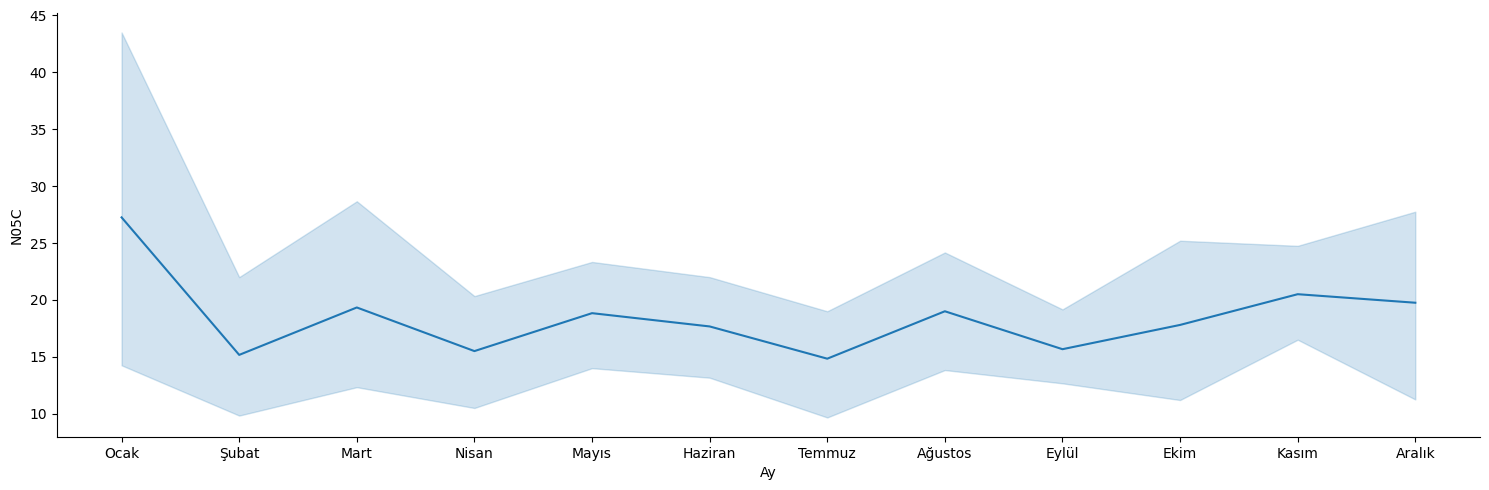

In [20]:
sns.relplot(kind='line', data=df_monthly, x='Ay', y='N05C', palette="flare", aspect=3)

* BU ilaç türünün kullanımı mevsimlerden bağımsız ve düzenli kullanılan ilaçlar olduğu için aylara göre ciddi bir değişim gözlemlenmemektedir.

### Yıllara Göre R03 İlaç Kategorisinin Ay Bazında Satış Rakamları

* **RO3:** Obstrüktif hava yolu hastalıkları için kullanılan ilaç grubudur. Örnek olarak çok sık görülmekte olan bir hastalık olan Koah verilebilir.

* KOAH [Kronik (Müzmin) Obstrüktif (Tıkayıcı) Akciğer Hastalığı] nefes yollarında mikroplarla oluşmayan bir iltihaplanmaya bağlı oluşan ilerleyici bir akciğer hastalığıdır. Küresel Hastalık Yükü Çalışması verilerine göre, KOAH yılda 2.9 milyon ölüme neden olmaktadır. Günümüzde tüm dünyada 3. ölüm nedeni haline gelen KOAH, tüm ölümlerin de %5.5’inden sorumludur. Türkiye’de solunum sistemi hastalıkları en sık görülen 3. ölüm nedenidir ve bu ölümlerin  %61.5’i KOAH nedeniyledir. Toplumun KOAH konusunda yeterli bilgiye sahip olmaması, hastalığın erken tanısını ve etkin tedavisini güçleştirmektedir.

Kaynakça: https://hsgm.saglik.gov.tr/tr/kronik-hava-yolu-hastaliklari/liste/kronik-hava-yolu-hastal%C4%B1klar%C4%B1-koah.html

<ipython-input-21-f60325cde746>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(kind='line', data=df_monthly, x='Ay', y='R03', palette="flare", aspect=3)


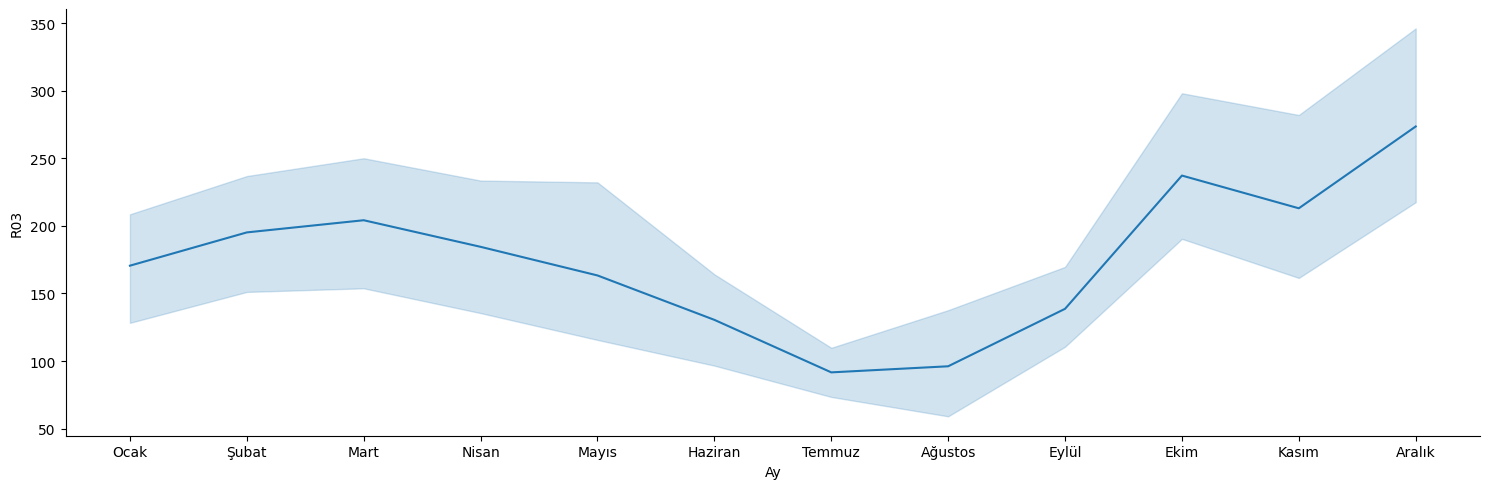

In [21]:
sns.relplot(kind='line', data=df_monthly, x='Ay', y='R03', palette="flare", aspect=3)

* Üst solunum yolları ile alakalı olan hastalıklar daha çok sonbahar, kış ve ilkbahar aylarında artış göstermektedir. Bunun sebebi ise hafif seyreden üst solunum yolları ile alakalı hastalıkların kümülatif toplamı ile birlikte daha ağır sonuçlar içeren Bronşit, Zatüre ve Astım vb. gibi hastalıklara zemin hazırlamaktadırlar. Bu sebep ile bu mevsimlerde yaz aylarına göre ilaç satışları gözle görülür bir şekile artmaktadır.

### Yıllara Göre R06 İlaç Kategorisinin Ay Bazında Satış Rakamları

* **R06:** - Sistemik kullanım için antihistaminikler ilaçlar.

* Antihistaminik, histaminin etkisini önleyen maddelerdir. Histamin, kişinin alerjik olduğu madde ile karşılaştığında veya iltihap durumlarında ortaya çıkan önemli bir kimyasal ajandır. En iyi sonuç için bu ilaçlar alerji şikayetleri ortaya çıkmadan alınmalıdırlar.

* Antihistaminiklerin ortaya çıkardığı en sıkıcı yan etki "uyku hâli" vermeleridir. Bu durum gece yatmadan önce alındığında iyi olabilse de gündüz sıkıntı yaratabilir. Hatta bazen zararlı olabilir. Araba veya tehlikeli olabilecek makine kullananlara bu ilaçlar önerilmez. İlk dozlar en fazla uyku verirler, sonraki dozlarda biraz bağışıklık gelişir.

Kaynakça: https://tr.wikipedia.org/wiki/Antihistaminik

<ipython-input-22-154fdb087732>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(kind='line', data=df_monthly, x='Ay', y='R06', palette="flare", aspect=3)


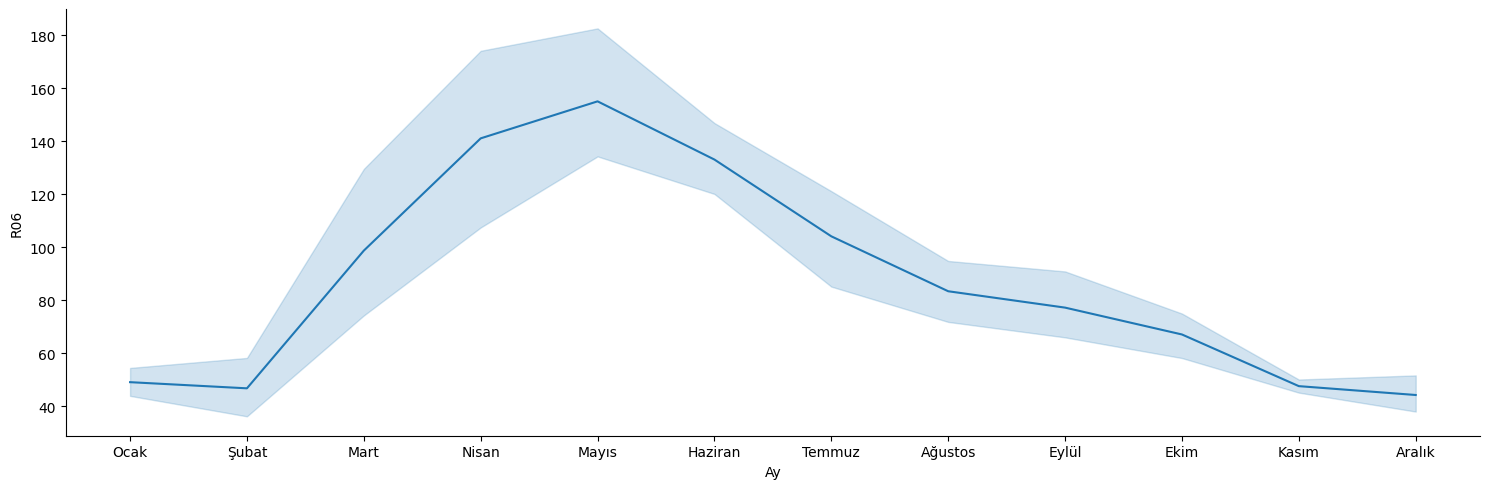

In [22]:
sns.relplot(kind='line', data=df_monthly, x='Ay', y='R06', palette="flare", aspect=3)

* Grafik incelendiği takdirde, ilkbahar aylarından yaz aylarına geçiş döneminde ilaç satışlarında ciddi bir artış gerçekleşmiştir. Bunun başlıca sebebi ise polen, toz, bitki ve güneş vb. etkenler sebebi ile oluşan alerjilere karşı kullanılan bu alerji ilaçlarının kullanımının artmasıdır.

### Numerik Sınıfların Korelasyon Grafiği

* Bu analiz yönteminde genel olarak sınıflar arasında ikili ilişkiler inceleyeceğiz. Bunun en iyi yolu ise korelasyon grafiği çıkartmaktır. BU sebep ile cluster map aracılığı ile korelasyon değerlerinin grafiğini oluşturma yoluna gittik.

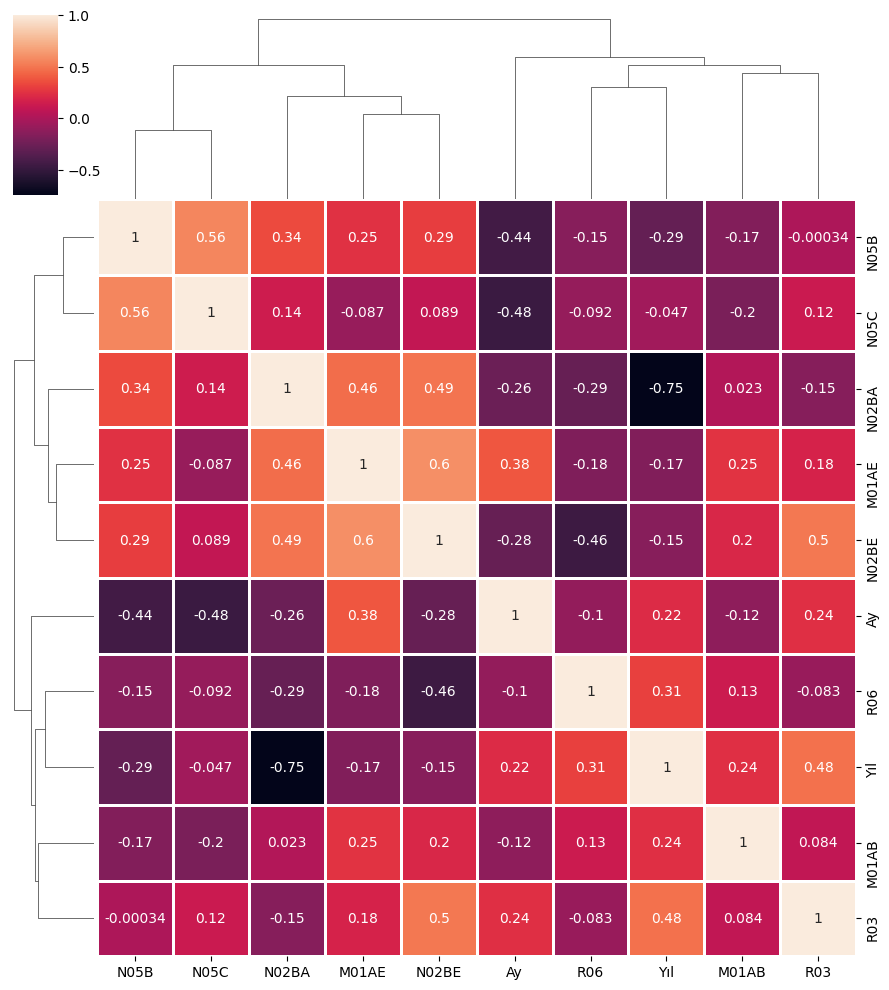

In [25]:
# Convert the 'Ay' column to a numerical representation if it represents months
# For example, if 'Ocak' is January, you can map it to 1, and so on.
month_mapping = {'Ocak': 1, 'Şubat': 2}
# Complete the mapping for all months
df_monthly['Ay'] = df_monthly['Ay'].map(month_mapping)

sns.clustermap(df_monthly.corr(), dendrogram_ratio=(0.1, 0.2), annot=True, linewidths=0.8, figsize=(9, 10))
plt.show()

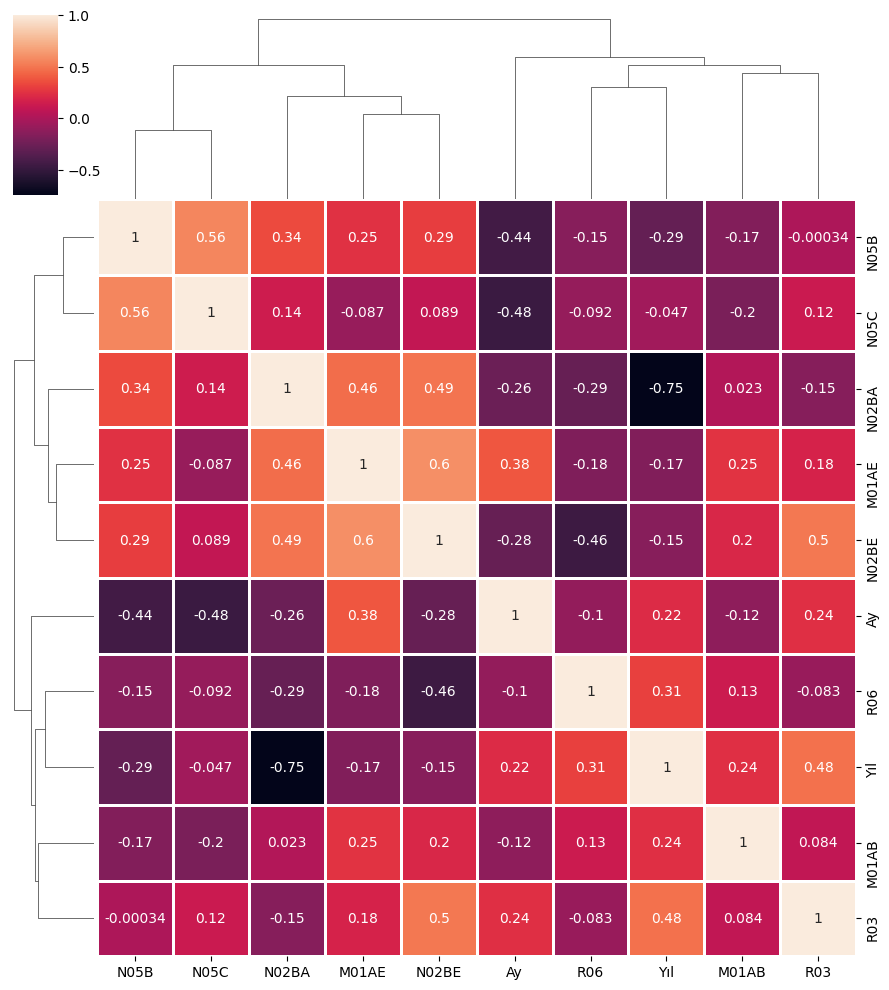

In [26]:
sns.clustermap(df_monthly.corr(), dendrogram_ratio = (0.1, 0.2), annot = True, linewidths = 0.8, figsize = (9, 10))
plt.show()

* Öncelikle dikkat çekici benzerlik seviyesi içeren ikilileri sıralayacağız:
 * M01AE - N02BE --> 0.6
 * N02BA - N02BE --> 0.49
 * R03 - N02BE --> 0.5
 * R06 - N02BE --> -046
 * N02A - M01AE --> 0.46
 * N05B - N02BA --> 0.34
 * N05B - N05C --> 0.56

* Yukarı görüldüğü üzere birçok ikili ilişki göze çarpmaktadır. Bunun birçoğunun sebebi ise aslında bu ilaç türlerinin kullanıldığı hastalıkların semptomlarındaki benzerliklerdir. Yani aslında ilaçlar benzer amaçlara farklı tipteki etken hammaddeler ile çözüm sunmalarıdır.

* Fakat bu durumla alakası olmayan dikkat çekici bir takım ilişki de göze çarpmaktadır, bunlardan örnek olarak belirtmek gerekir ise alerji ilaçları ile psikolojik sorunlara karşı kullanılan ilaçlar arasında pozitif bir korelasyon görülmektedir. Örnek olarak birkaçını göstermek gerekirse;
 * M01AE - N02B Çifti, R03 - N02BE Çifti, R06 - N02BE, N02A - M01AE.

## Geleceğe Yönelik Satış Rakamları Tahmininde Bulunma

* Bu proje kapsamında gelecek satış rakamlarının tahmin edilmesi amacıyla kullanılmak üzere XGBoost isimli makine öğrenmesi moeli seçildi. Bunun sebebi ise bu model tablo tipi verilerde çok güçlü durumda ve zaman serisi verilerini de iyi bir şekilde tahlil edebiliyor olmasıdır.

* Bu kısımda tek tek tüm ilaç sınıflarını zaman bilgilerine göre ayırıp sonrasında bu zaman bilgilerine karşılık satış rakamlarını kullandığımız bir veri seti ve buna karşılık XGBoost kütüphanesinde bulunan XGBoost Regresyon modeli ile eğitim gerçekleştireceğiz. Bu model aracılığı ile ise veri setimizden test verisi olarak seçtiğimiz 2019 yılı hakkında tahminde bulunup gerçek sonuçları ile grafik üzerinde karşılaştıracağız.

### M01AB Sınıfına Yönelik Gelecek Satış Tahmini

In [27]:
df = pd.read_csv("/kaggle/input/pharma-sales-data/salesweekly.csv", index_col=[0], parse_dates=[0])
df = df.drop(['M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axis = 1)
# bulunan aykırı değerleri veri setimizden atılacaktır.
df = df.drop(detect_outliers(df,["M01AB"]),axis=0)

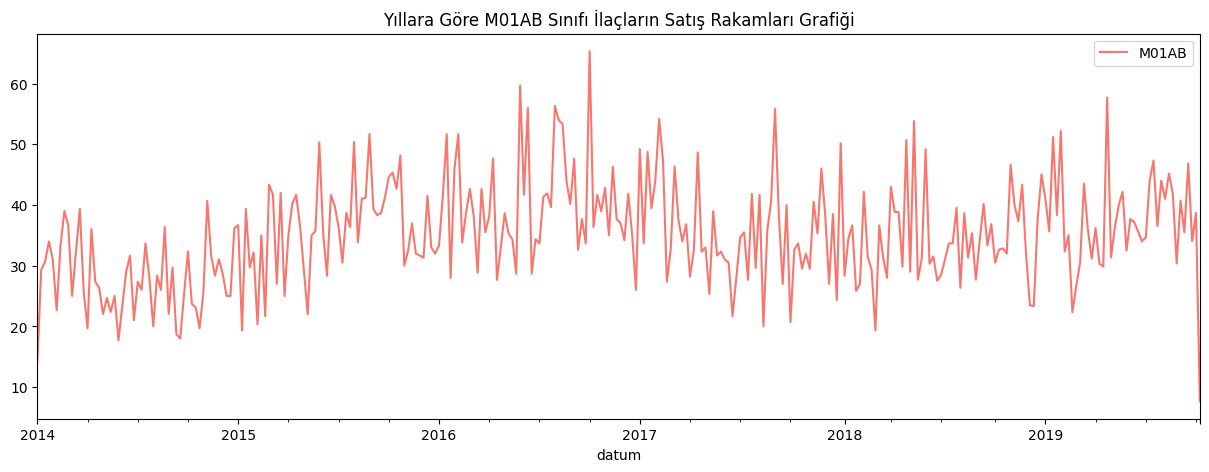

In [28]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='-', figsize=(15,5), color=color_pal[0], title='Yıllara Göre M01AB Sınıfı İlaçların Satış Rakamları Grafiği')

In [29]:
split_date = '01-Jan-2019'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

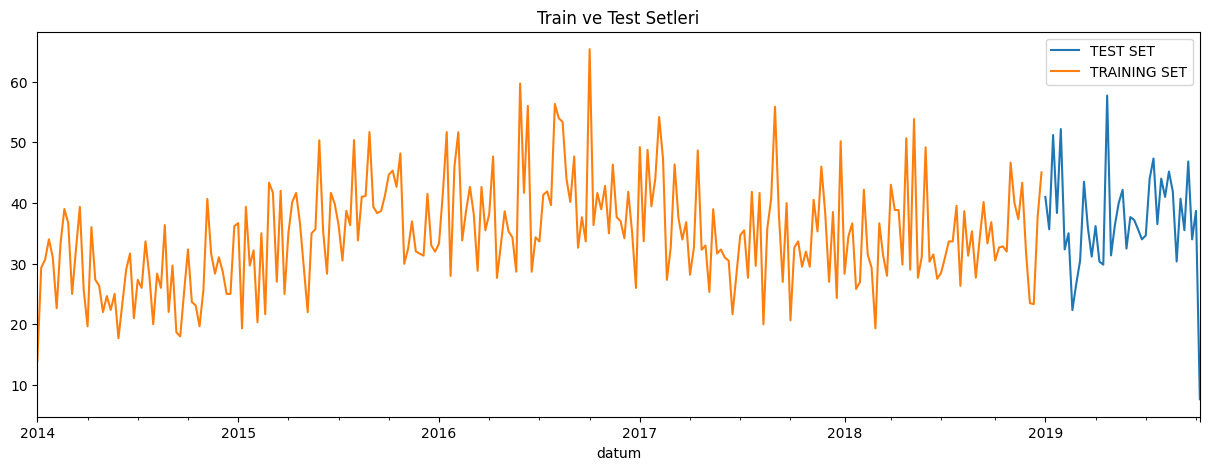

In [30]:
_ = df_test \
    .rename(columns={'M01AB': 'TEST SET'}) \
    .join(df_train.rename(columns={'M01AB': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Train ve Test Setleri', style='-')

In [31]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['quarter','month','year',
           ]]
    if label:
        y = df[label]
        return X, y
    return X

In [33]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    # Apply weekofyear to each datetime object in the Series
    df['weekofyear'] = df['date'].apply(lambda x: x.weekofyear)

    X = df[['quarter','month','year',
           ]]
    if label:
        y = df[label]
        return X, y
    return X

In [34]:
X_train, y_train = create_features(df_train, label='M01AB')
X_test, y_test = create_features(df_test, label='M01AB')

In [35]:
X_train.head()

,quarter,month,year
datum,,,
2014-01-05,1,1,2014
2014-01-12,1,1,2014
2014-01-19,1,1,2014
2014-01-26,1,1,2014
2014-02-02,1,2,2014


In [39]:
# Import the necessary module
import xgboost as xgb

# Assuming X_train, y_train, X_test, and y_test are already defined

# Create DMatrix objects for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters for training
param = {'objective': 'reg:squarederror'}  # Example objective, adjust as needed
evallist = [(dtest, 'eval'), (dtrain, 'train')]

# Train the model using xgb.train with early stopping
num_round = 1000
reg = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=50, verbose_eval=False)

# Now you can use the trained model 'reg' for predictions

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [38]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

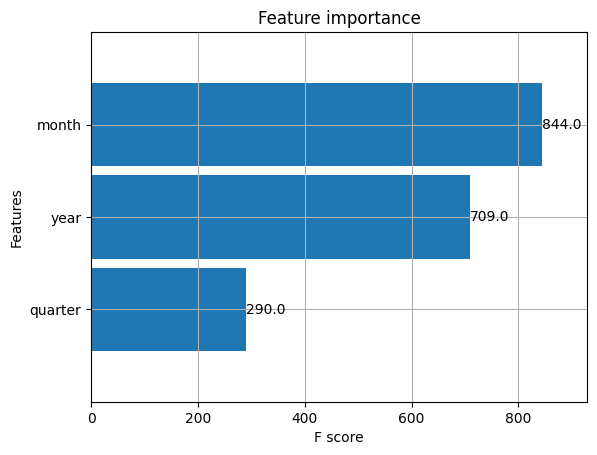

In [40]:
_ = plot_importance(reg, height=0.9)

In [44]:
# Convert X_test to DMatrix
dtest = xgb.DMatrix(X_test)

# Now predict using the DMatrix
df_test['M01AB_Prediction'] = reg.predict(dtest)
df_all = pd.concat([df_test, df_train], sort=False)

In [43]:
df_test['M01AB_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

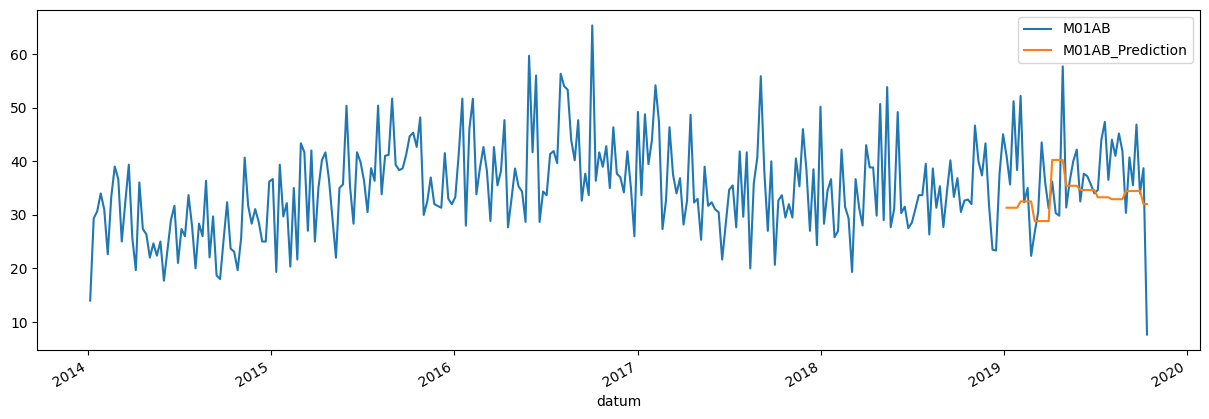

In [45]:
_ = df_all[['M01AB','M01AB_Prediction']].plot(figsize=(15, 5))

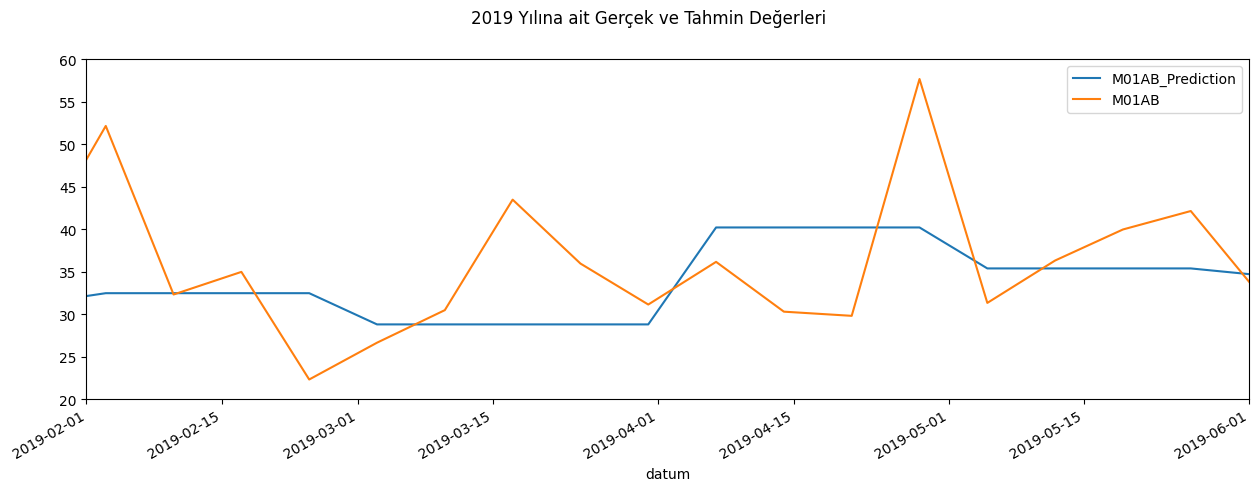

In [46]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['M01AB_Prediction','M01AB']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='02-01-2019', upper='06-01-2019')
ax.set_ylim(20, 60)
plot = plt.suptitle('2019 Yılına ait Gerçek ve Tahmin Değerleri')

###

### M01AE Sınıfına Yönelik Gelecek Satış Tahmini

In [86]:
df = pd.read_csv("/kaggle/input/pharma-sales-data/salesmonthly.csv", index_col=[0], parse_dates=[0])
df = df.drop(['M01AB','N02BA','N02BE', 'N05B','N05C','R03','R06'], axis = 1)
#df = df.drop(detect_outliers(df,["M01AE"]),axis=0)

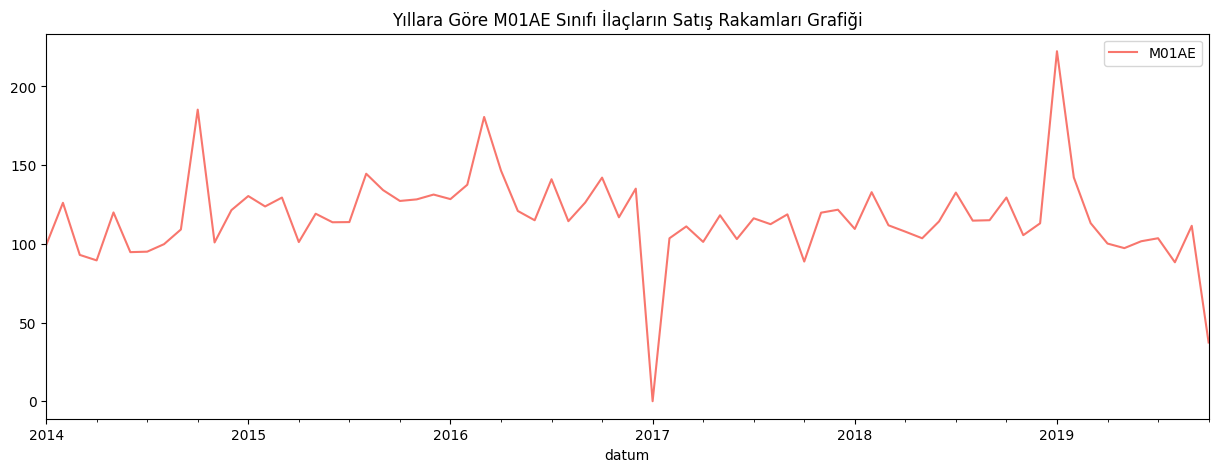

In [87]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='-', figsize=(15,5), color=color_pal[0], title='Yıllara Göre M01AE Sınıfı İlaçların Satış Rakamları Grafiği')

In [88]:
split_date = '01-Jan-2019'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

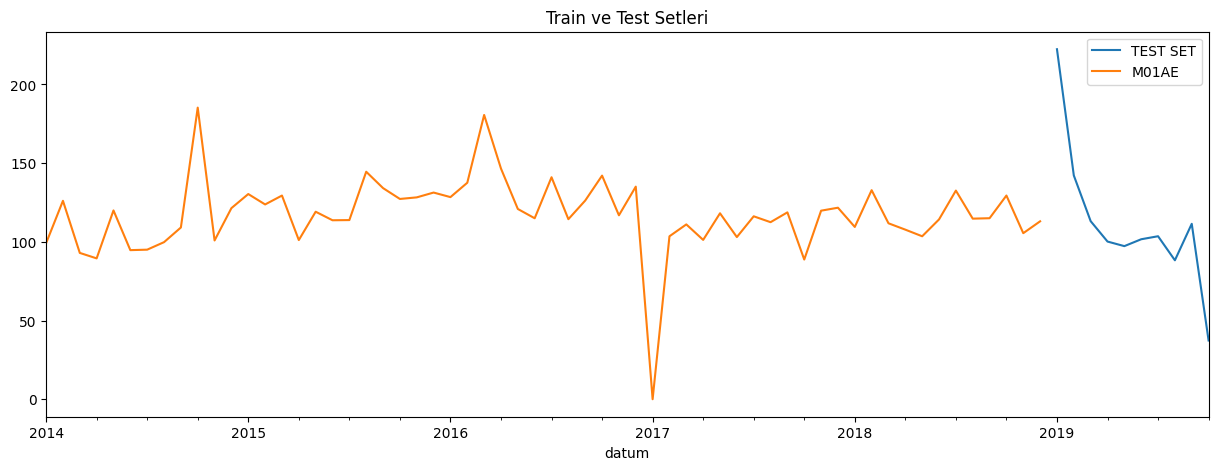

In [89]:
_ = df_test \
    .rename(columns={'M01AE': 'TEST SET'}) \
    .join(df_train.rename(columns={'M01AB': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Train ve Test Setleri', style='-')

In [90]:
X_train, y_train = create_features(df_train, label='M01AE')
X_test, y_test = create_features(df_test, label='M01AE')

In [91]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    #early_stopping_rounds=50,
    verbose=True  # Change to True if you want to see training logs
)

[0]	validation_0-rmse:20.01798	validation_1-rmse:45.15812
[1]	validation_0-rmse:17.09443	validation_1-rmse:45.47429
[2]	validation_0-rmse:14.86309	validation_1-rmse:45.41429
[3]	validation_0-rmse:13.10597	validation_1-rmse:45.65377
[4]	validation_0-rmse:11.67155	validation_1-rmse:45.64955
[5]	validation_0-rmse:10.51248	validation_1-rmse:45.85597
[6]	validation_0-rmse:9.23492	validation_1-rmse:45.94906
[7]	validation_0-rmse:8.44234	validation_1-rmse:45.96164
[8]	validation_0-rmse:7.77169	validation_1-rmse:45.92546
[9]	validation_0-rmse:7.27657	validation_1-rmse:45.97447
[10]	validation_0-rmse:6.90823	validation_1-rmse:46.01595
[11]	validation_0-rmse:6.39934	validation_1-rmse:46.03288
[12]	validation_0-rmse:6.08489	validation_1-rmse:46.20015
[13]	validation_0-rmse:5.42391	validation_1-rmse:46.33274
[14]	validation_0-rmse:5.25855	validation_1-rmse:46.38146
[15]	validation_0-rmse:4.84439	validation_1-rmse:46.37340
[16]	validation_0-rmse:4.61447	validation_1-rmse:46.35532
[17]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

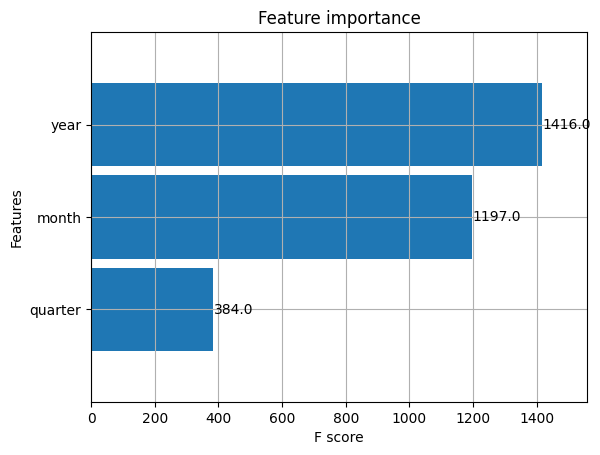

In [94]:
_ = plot_importance(reg, height=0.9)

In [95]:
df_test['M01AE_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

Columns in df_test: Index(['M01AE', 'date', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'M01AE_Prediction'],
      dtype='object')
Columns in df_train: Index(['M01AE', 'date', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')


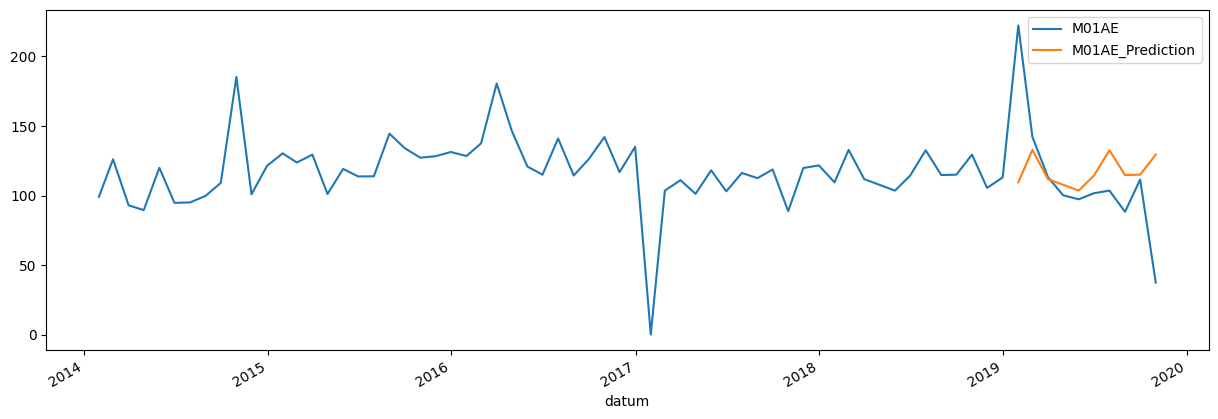

In [96]:
print("Columns in df_test:", df_test.columns)
print("Columns in df_train:", df_train.columns)

df_all = pd.concat([df_test, df_train], sort=False)

_ = df_all[['M01AE','M01AE_Prediction']].plot(figsize=(15, 5))

Columns in df_test: Index(['N02BA', 'date', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'M01AE_Prediction'],
      dtype='object')
Columns in df_train: Index(['N02BA', 'date', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')


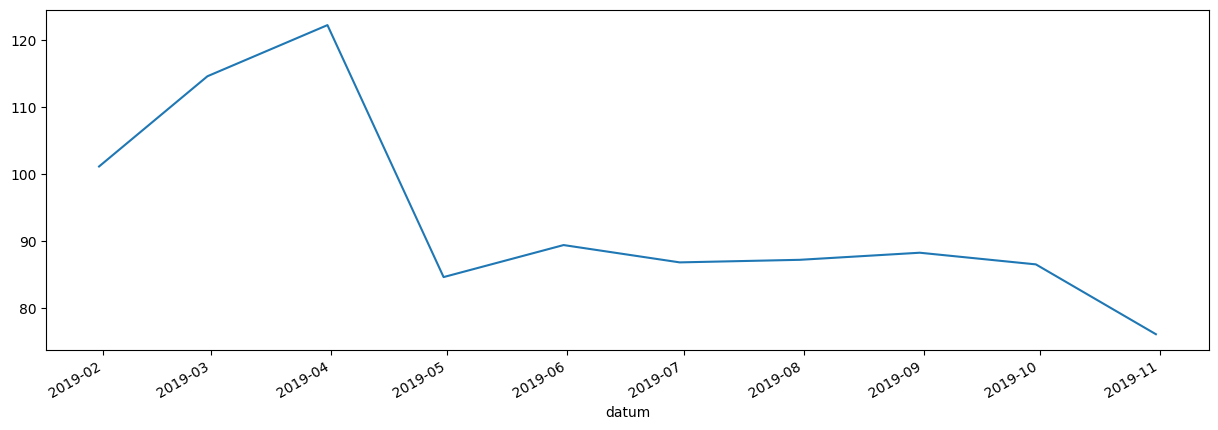

In [70]:
print("Columns in df_test:", df_test.columns)
print("Columns in df_train:", df_train.columns)

# Check if 'M01AE' is present in either DataFrame, if not, investigate why it's missing
# ... (your code to investigate the missing column)

df_all = pd.concat([df_test, df_train], sort=False)

# If 'M01AE' is genuinely not needed, just plot 'M01AE_Prediction'
_ = df_all['M01AE_Prediction'].plot(figsize=(15, 5))

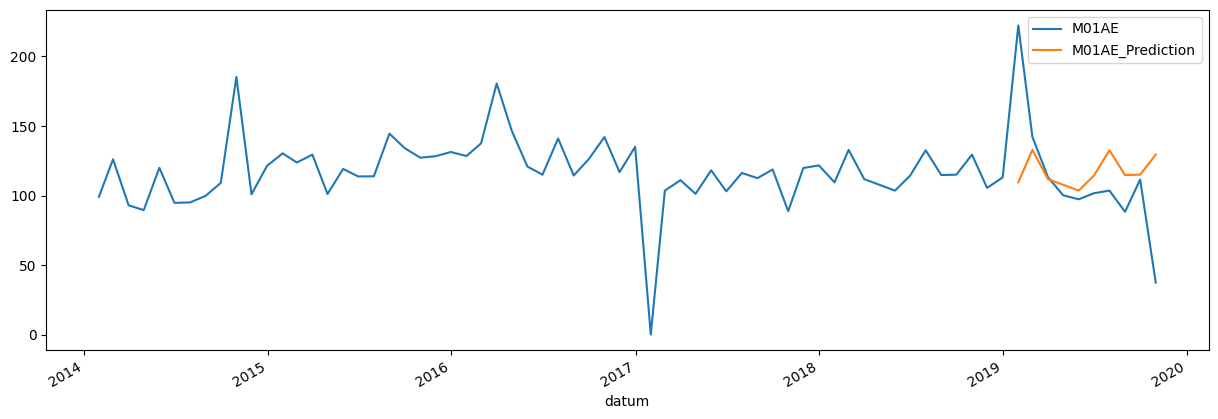

In [97]:
_ = df_all[['M01AE','M01AE_Prediction']].plot(figsize=(15, 5))

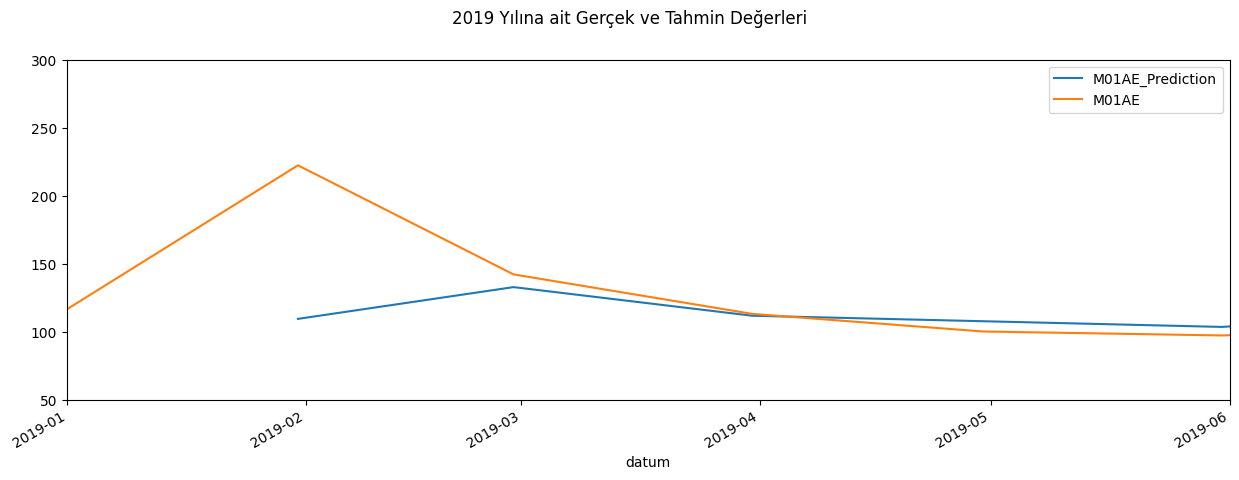

In [98]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['M01AE_Prediction','M01AE']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='01-01-2019', upper='06-01-2019')
ax.set_ylim(50, 300)
plot = plt.suptitle('2019 Yılına ait Gerçek ve Tahmin Değerleri')

### N02BA Sınıfına Yönelik Gelecek Satış Tahmini

In [54]:
df = pd.read_csv("/kaggle/input/pharma-sales-data/salesmonthly.csv", index_col=[0], parse_dates=[0])
df = df.drop(['M01AB','M01AE','N02BE', 'N05B','N05C','R03','R06'], axis = 1)

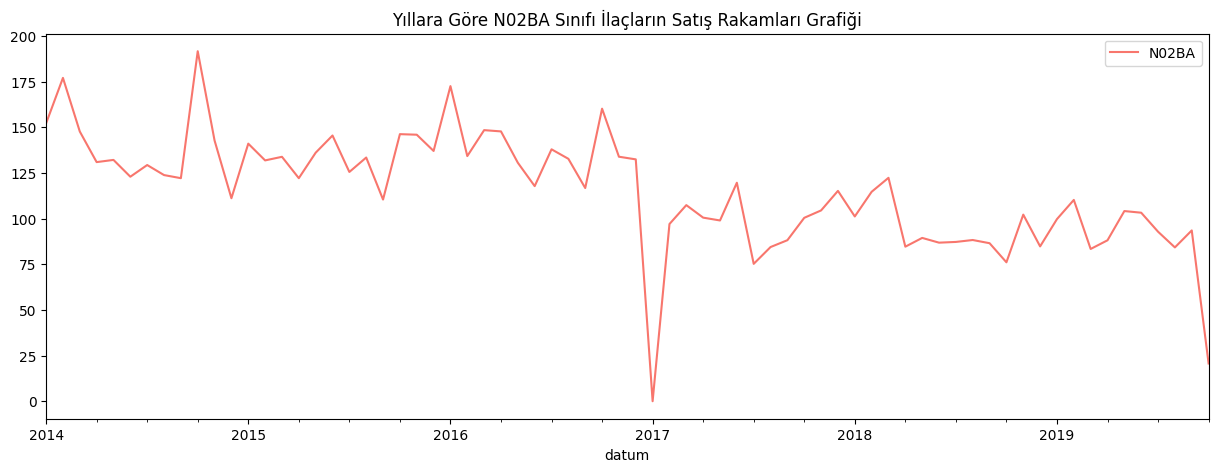

In [55]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='-', figsize=(15,5), color=color_pal[0], title='Yıllara Göre N02BA Sınıfı İlaçların Satış Rakamları Grafiği')

In [56]:
split_date = '01-Jan-2019'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

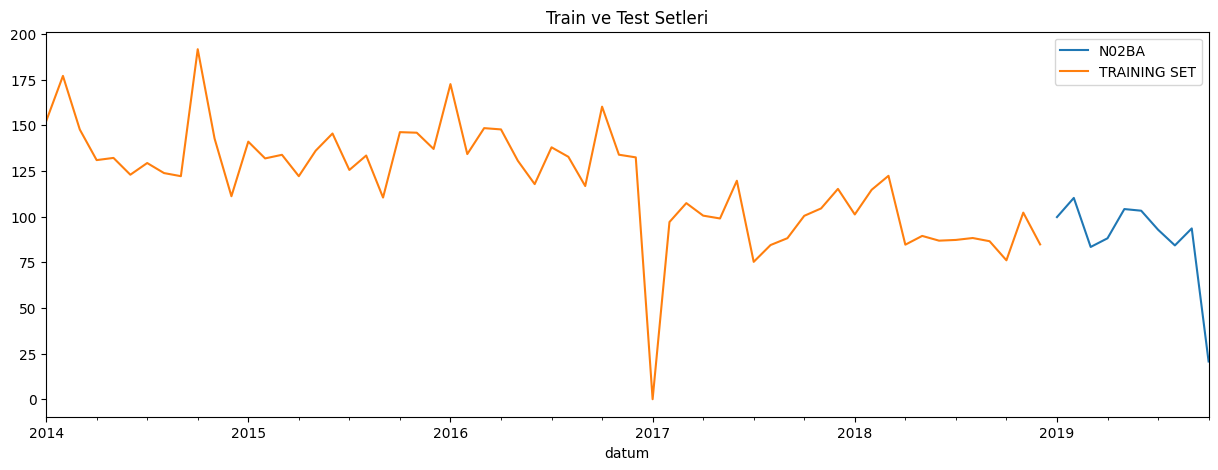

In [57]:
_ = df_test \
    .rename(columns={'M01AE': 'TEST SET'}) \
    .join(df_train.rename(columns={'N02BA': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Train ve Test Setleri', style='-')

In [58]:
X_train, y_train = create_features(df_train, label='N02BA')
X_test, y_test = create_features(df_test, label='N02BA')

In [69]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

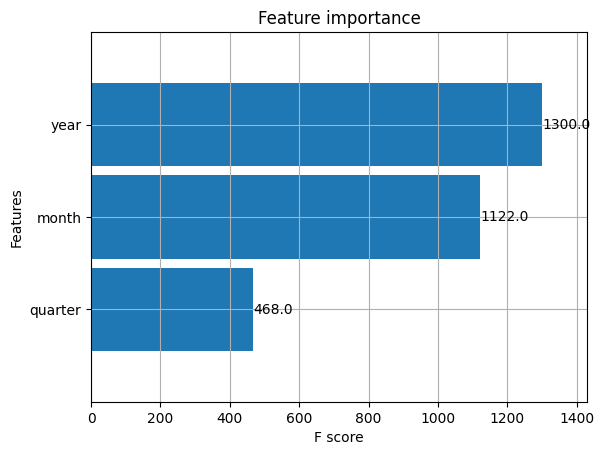

In [73]:
_ = plot_importance(reg, height=0.9)

In [74]:
df_test['N02BA_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

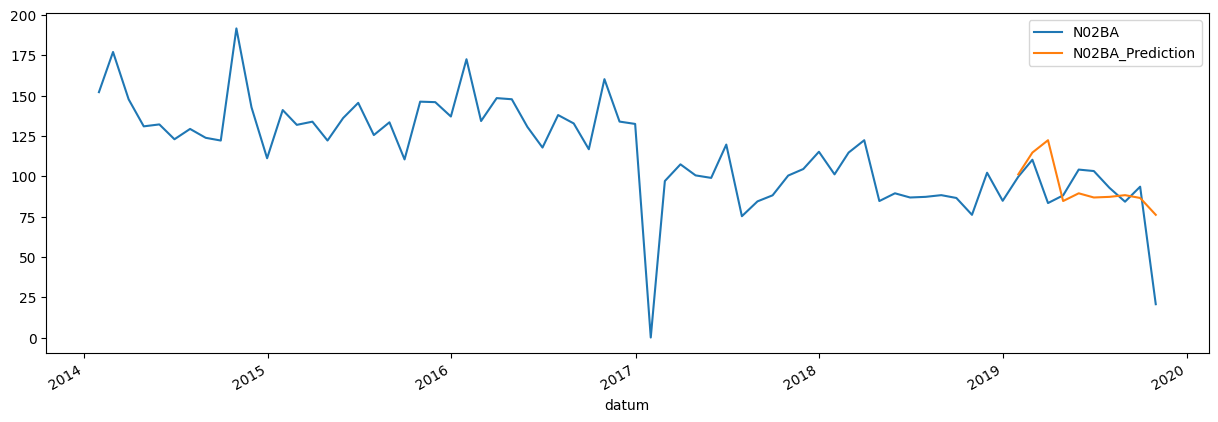

In [75]:
_ = df_all[['N02BA','N02BA_Prediction']].plot(figsize=(15, 5))

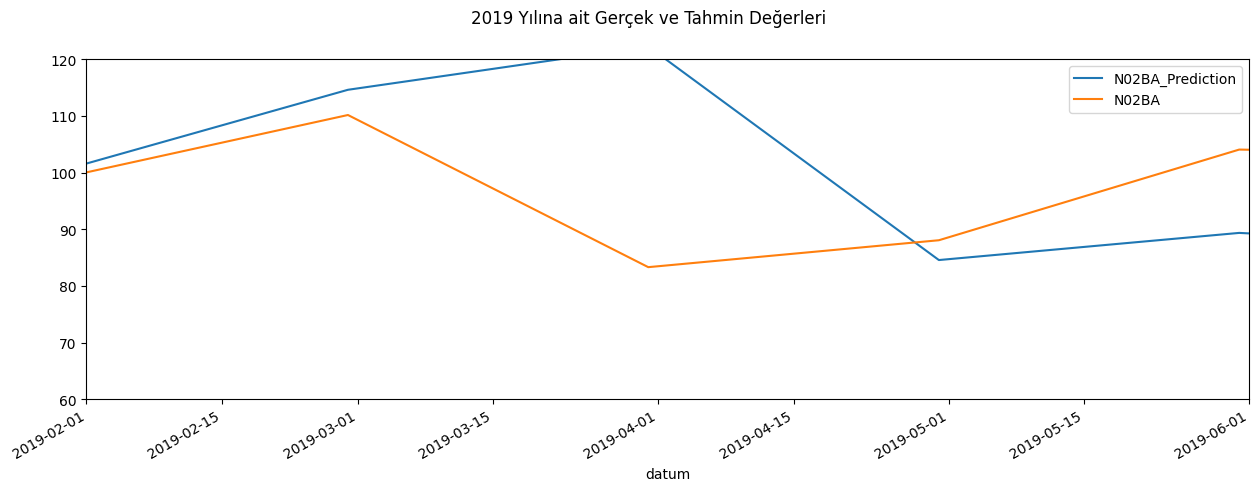

In [76]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['N02BA_Prediction','N02BA']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='02-01-2019', upper='06-01-2019')
ax.set_ylim(60, 120)
plot = plt.suptitle('2019 Yılına ait Gerçek ve Tahmin Değerleri')

### N02BE Sınıfına Yönelik Gelecek Satış Tahmini

In [77]:
df = pd.read_csv("/kaggle/input/pharma-sales-data/salesmonthly.csv", index_col=[0], parse_dates=[0])
df = df.drop(['M01AB','M01AE','N02BA', 'N05B','N05C','R03','R06'], axis = 1)

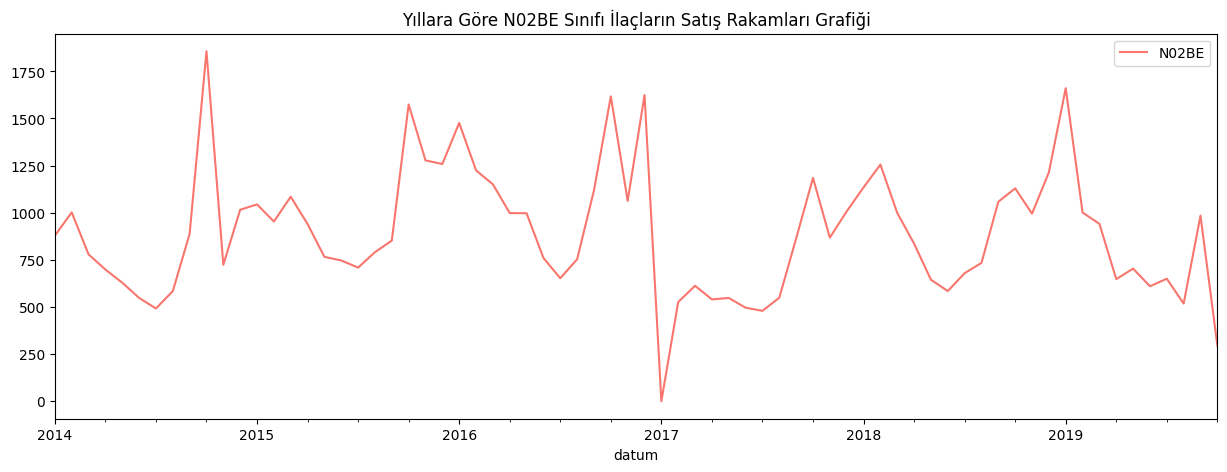

In [78]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='-', figsize=(15,5), color=color_pal[0], title='Yıllara Göre N02BE Sınıfı İlaçların Satış Rakamları Grafiği')

In [79]:
split_date = '01-Jan-2019'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

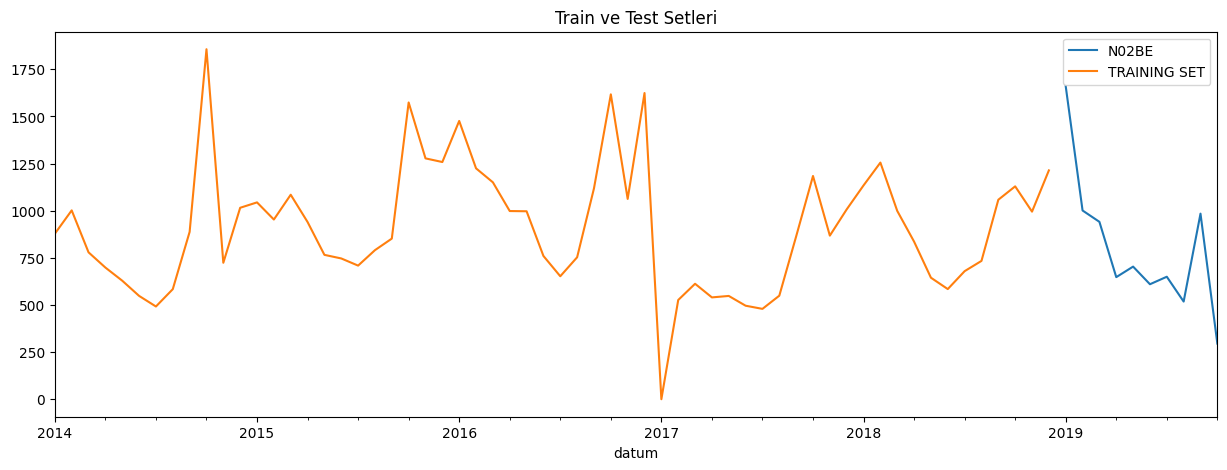

In [80]:
_ = df_test \
    .rename(columns={'M01AE': 'TEST SET'}) \
    .join(df_train.rename(columns={'N02BE': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Train ve Test Setleri', style='-')

In [81]:
X_train, y_train = create_features(df_train, label='N02BE')
X_test, y_test = create_features(df_test, label='N02BE')

In [82]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

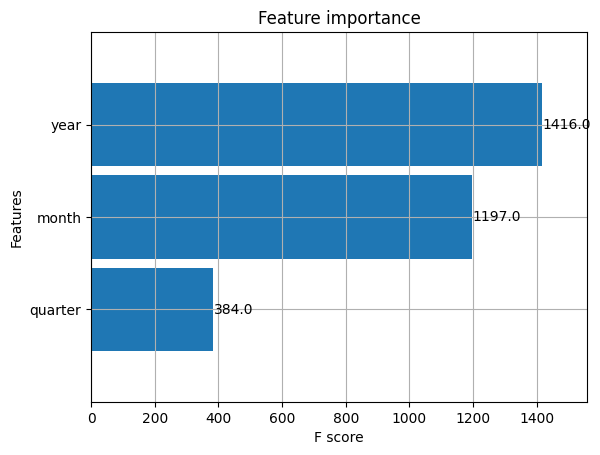

In [99]:
_ = plot_importance(reg, height=0.9)

In [100]:
df_test['N02BE_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [113]:
# Verify if 'N02BE' is in the original DataFrames
print("N02BE in df_test:", 'N02BE' in df_test.columns)
print("N02BE in df_train:", 'N02BE' in df_train.columns)

# If 'N02BE' is missing, investigate why and potentially fix the data loading or preprocessing steps.

# If 'N02BE' is present, check for typos in the column name and ensure it's included when creating 'df_all':
df_all = pd.concat([df_test, df_train], sort=False)

# Now try plotting again:
_ = df_all[['N02BE','N02BE_Prediction']].plot(figsize=(15, 5))

N02BE in df_test: False
N02BE in df_train: False


KeyError: "None of [Index(['N02BE', 'N02BE_Prediction'], dtype='object')] are in the [columns]"

In [102]:
# Verify if 'N02BE' is in the original DataFrames
print("N02BE in df_test:", 'N02BE' in df_test.columns)
print("N02BE in df_train:", 'N02BE' in df_train.columns)

# If 'N02BE' is missing, investigate why and potentially fix the data loading or preprocessing steps.

# If 'N02BE' is present, check for typos in the column name:
_ = df_all[['N02BE','N02BE_Prediction']].plot(figsize=(15, 5))

N02BE in df_test: False
N02BE in df_train: False


KeyError: "['N02BE'] not in index"

In [101]:
_ = df_all[['N02BE','N02BE_Prediction']].plot(figsize=(15, 5))

KeyError: "['N02BE'] not in index"

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['N02BE_Prediction','N02BE']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='02-01-2019', upper='06-01-2019')
ax.set_ylim(600, 1600)
plot = plt.suptitle('2019 Yılına ait Gerçek ve Tahmin Değerleri')

### N05B Sınıfına Yönelik Gelecek Satış Tahmini

In [103]:
df = pd.read_csv("/kaggle/input/pharma-sales-data/salesmonthly.csv", index_col=[0], parse_dates=[0])
df = df.drop(['M01AB','M01AE','N02BA', 'N02BE','N05C','R03','R06'], axis = 1)

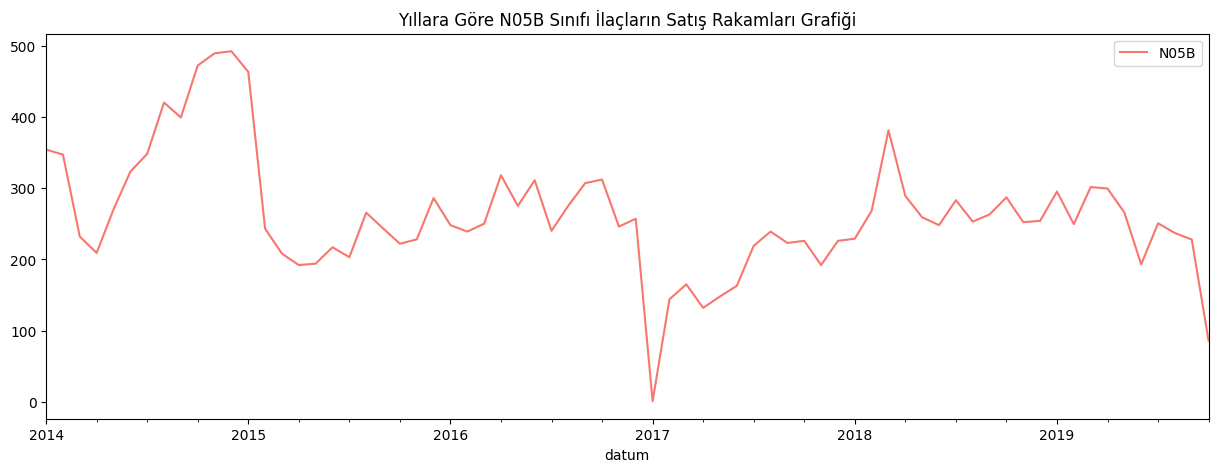

In [104]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='-', figsize=(15,5), color=color_pal[0], title='Yıllara Göre N05B Sınıfı İlaçların Satış Rakamları Grafiği')

In [105]:
split_date = '01-Jan-2019'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

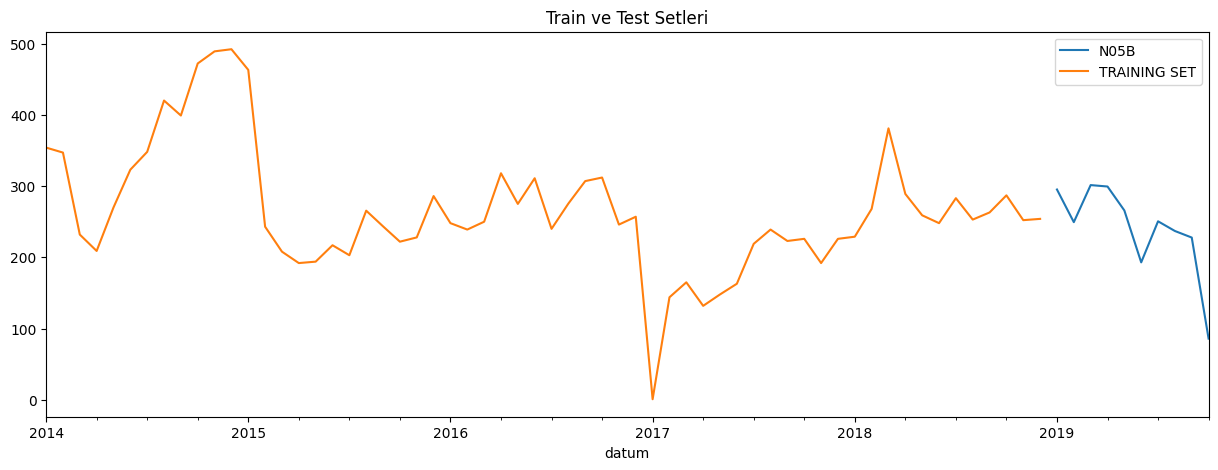

In [106]:
_ = df_test \
    .rename(columns={'M01AE': 'TEST SET'}) \
    .join(df_train.rename(columns={'N05B': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Train ve Test Setleri', style='-')

In [107]:
X_train, y_train = create_features(df_train, label='N05B')
X_test, y_test = create_features(df_test, label='N05B')

In [109]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

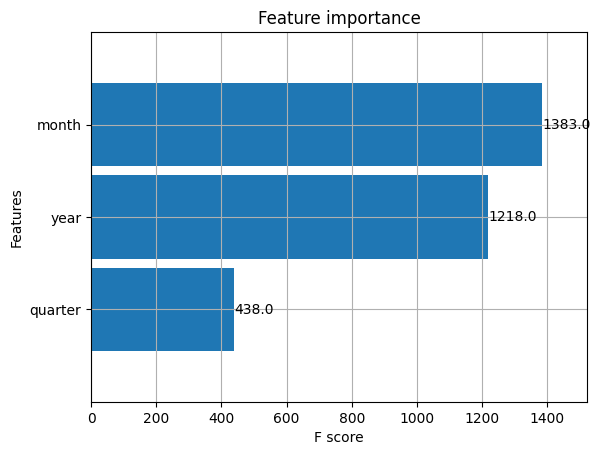

In [110]:
_ = plot_importance(reg, height=0.9)

In [111]:
df_test['N05B_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

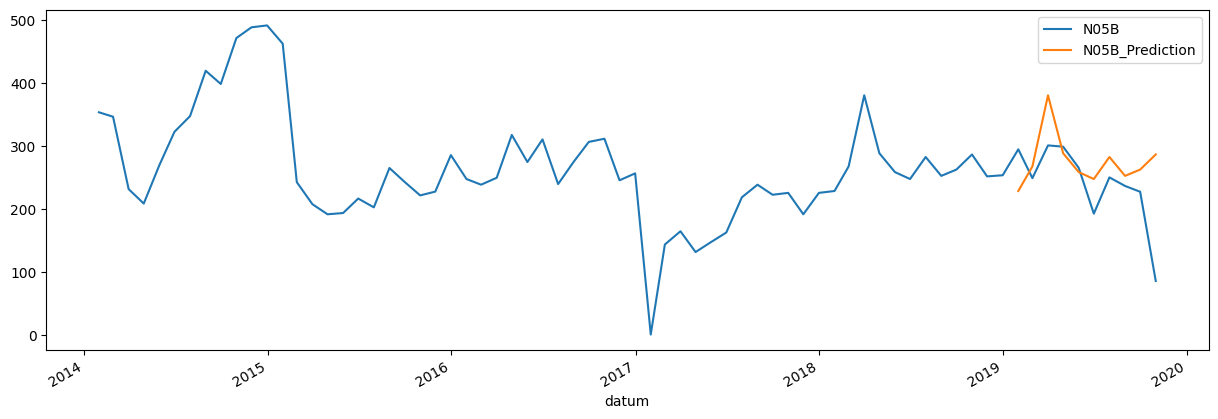

In [112]:
_ = df_all[['N05B','N05B_Prediction']].plot(figsize=(15, 5))

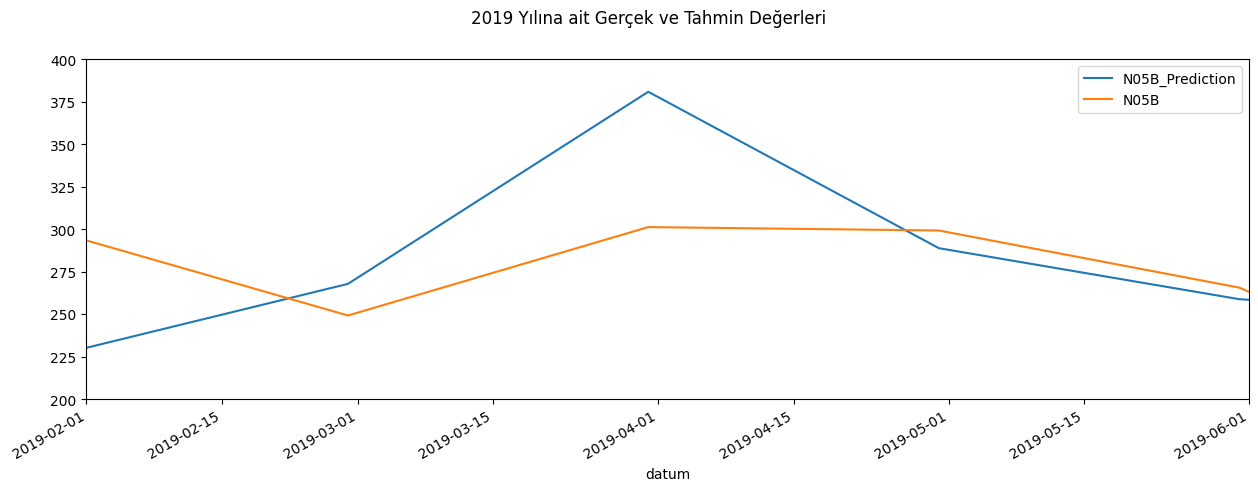

In [114]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['N05B_Prediction','N05B']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='02-01-2019', upper='06-01-2019')
ax.set_ylim(200, 400)
plot = plt.suptitle('2019 Yılına ait Gerçek ve Tahmin Değerleri')

### N05C Sınıfına Yönelik Gelecek Satış Tahmini

In [115]:
df = pd.read_csv("/kaggle/input/pharma-sales-data/salesmonthly.csv", index_col=[0], parse_dates=[0])
df = df.drop(['M01AB','M01AE','N02BA', 'N02BE','N05B','R03','R06'], axis = 1)

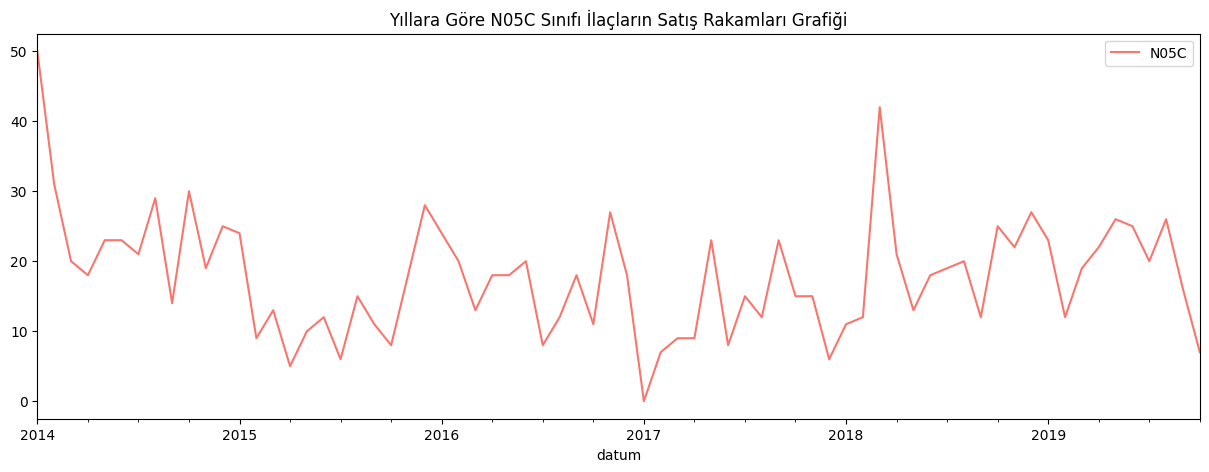

In [116]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='-', figsize=(15,5), color=color_pal[0], title='Yıllara Göre N05C Sınıfı İlaçların Satış Rakamları Grafiği')

In [117]:
split_date = '01-Jan-2019'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

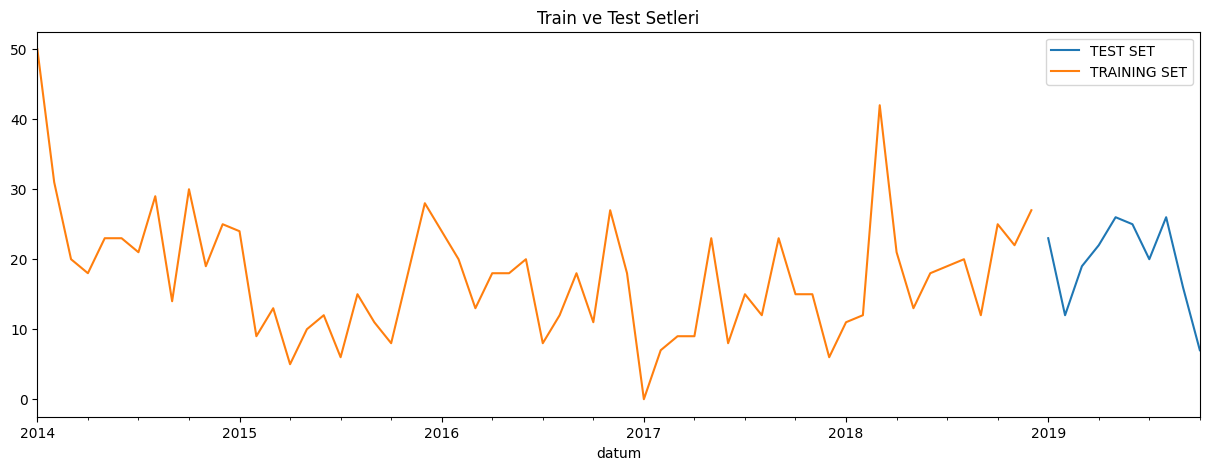

In [118]:
_ = df_test \
    .rename(columns={'N05C': 'TEST SET'}) \
    .join(df_train.rename(columns={'N05C': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Train ve Test Setleri', style='-')

In [119]:
X_train, y_train = create_features(df_train, label='N05C')
X_test, y_test = create_features(df_test, label='N05C')

In [120]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

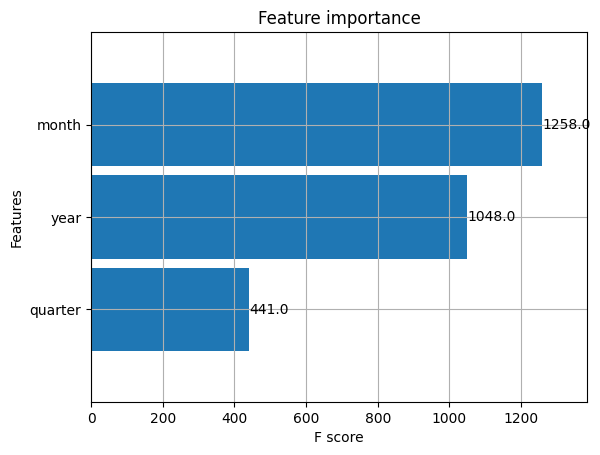

In [121]:
_ = plot_importance(reg, height=0.9)

In [122]:
df_test['N05C_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

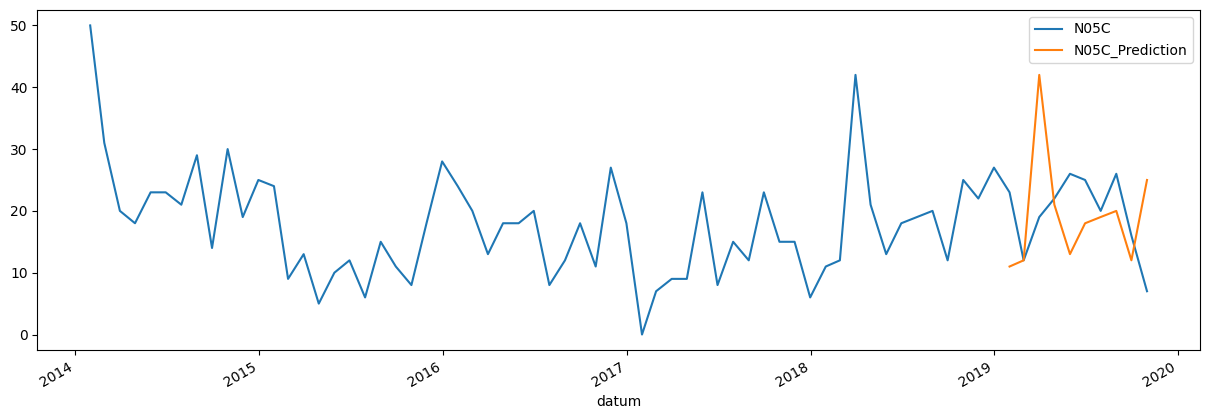

In [123]:
_ = df_all[['N05C','N05C_Prediction']].plot(figsize=(15, 5))

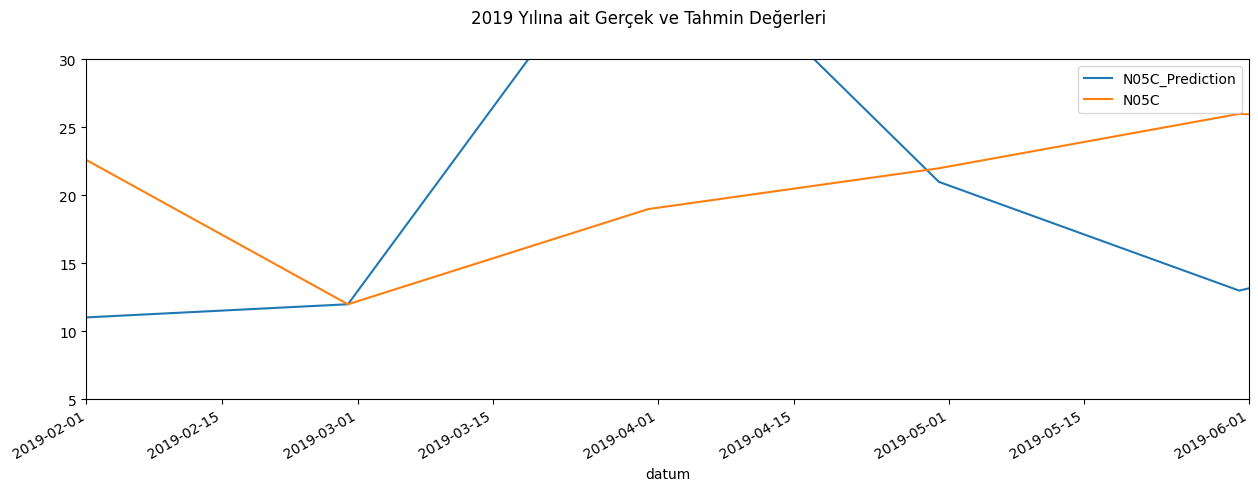

In [124]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['N05C_Prediction','N05C']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='02-01-2019', upper='06-01-2019')
ax.set_ylim(5, 30)
plot = plt.suptitle('2019 Yılına ait Gerçek ve Tahmin Değerleri')

### R03 Sınıfına Yönelik Gelecek Satış Tahmini

In [125]:
df = pd.read_csv("/kaggle/input/pharma-sales-data/salesmonthly.csv", index_col=[0], parse_dates=[0])
df = df.drop(['M01AB','M01AE','N02BA', 'N02BE','N05B','N05C','R06'], axis = 1)

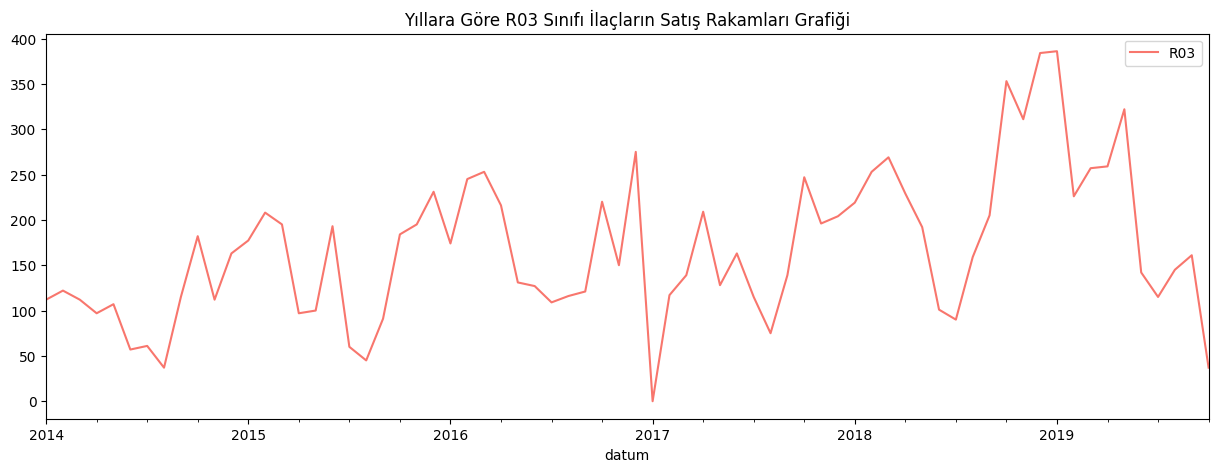

In [126]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='-', figsize=(15,5), color=color_pal[0], title='Yıllara Göre R03 Sınıfı İlaçların Satış Rakamları Grafiği')

In [127]:
split_date = '01-Jan-2019'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

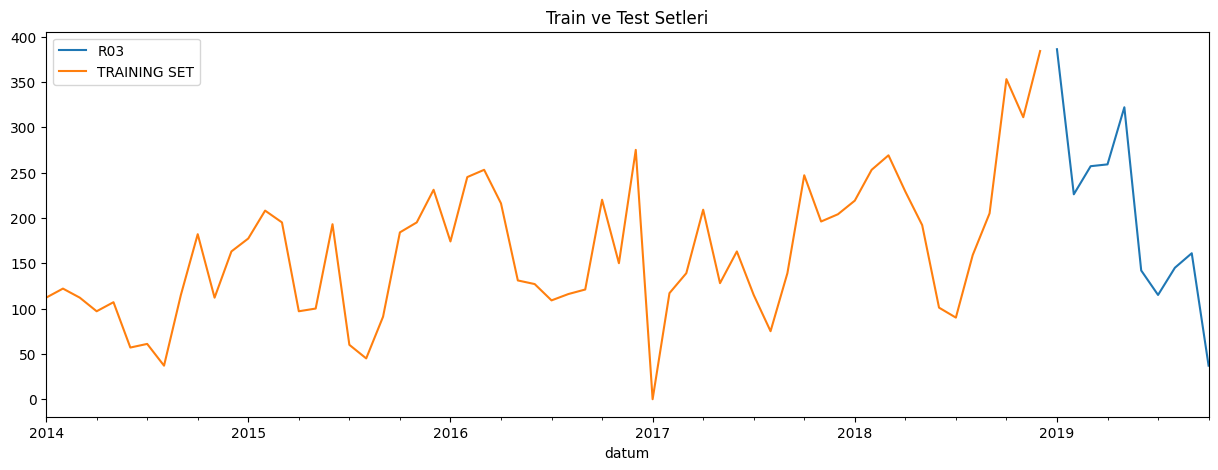

In [128]:
_ = df_test \
    .rename(columns={'N05C': 'TEST SET'}) \
    .join(df_train.rename(columns={'R03': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Train ve Test Setleri', style='-')

In [129]:
X_train, y_train = create_features(df_train, label='R03')
X_test, y_test = create_features(df_test, label='R03')

In [130]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

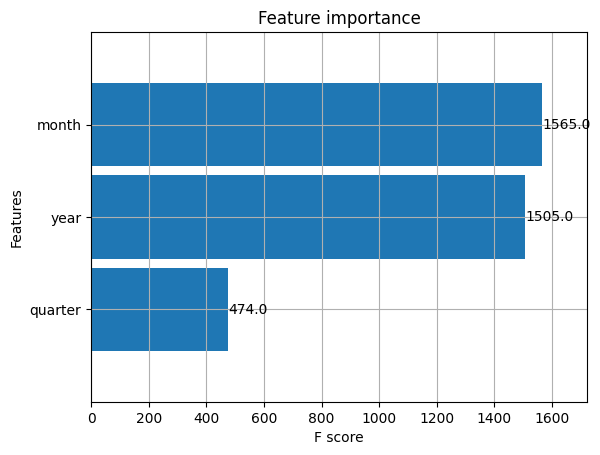

In [131]:
_ = plot_importance(reg, height=0.9)

In [132]:
df_test['R03_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

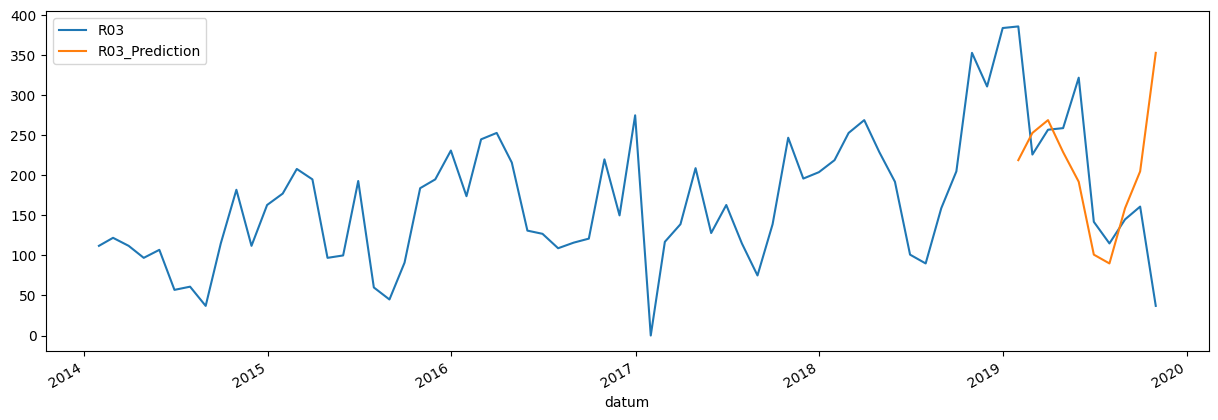

In [133]:
_ = df_all[['R03','R03_Prediction']].plot(figsize=(15, 5))

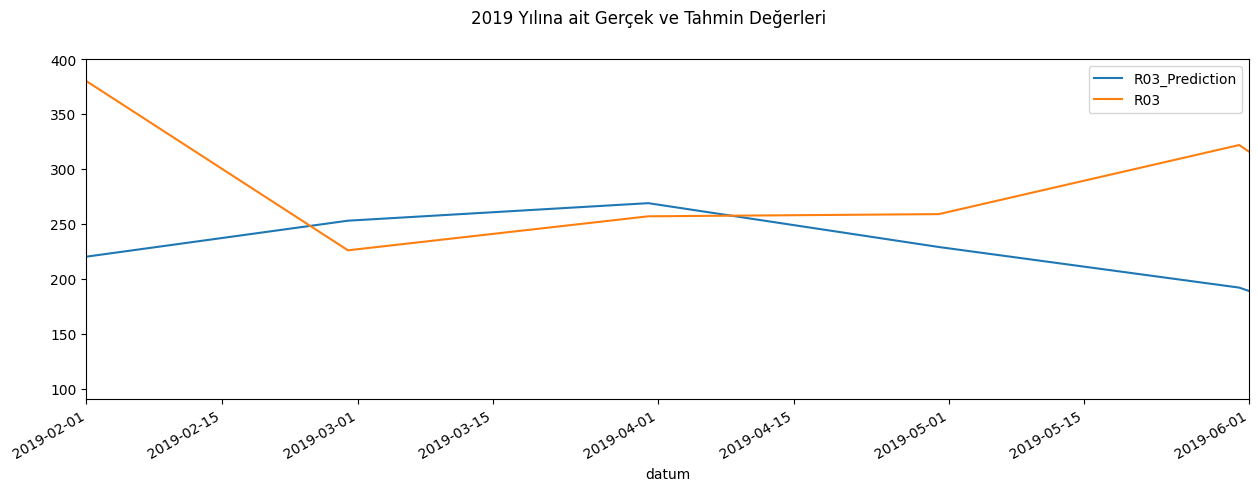

In [134]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['R03_Prediction','R03']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='02-01-2019', upper='06-01-2019')
ax.set_ylim(90, 400)
plot = plt.suptitle('2019 Yılına ait Gerçek ve Tahmin Değerleri')

### R06 Sınıfına Yönelik Gelecek Satış Tahmini

In [135]:
df = pd.read_csv("/kaggle/input/pharma-sales-data/salesmonthly.csv", index_col=[0], parse_dates=[0])
df = df.drop(['M01AB','M01AE','N02BA', 'N02BE','N05B','N05C','R03'], axis = 1)

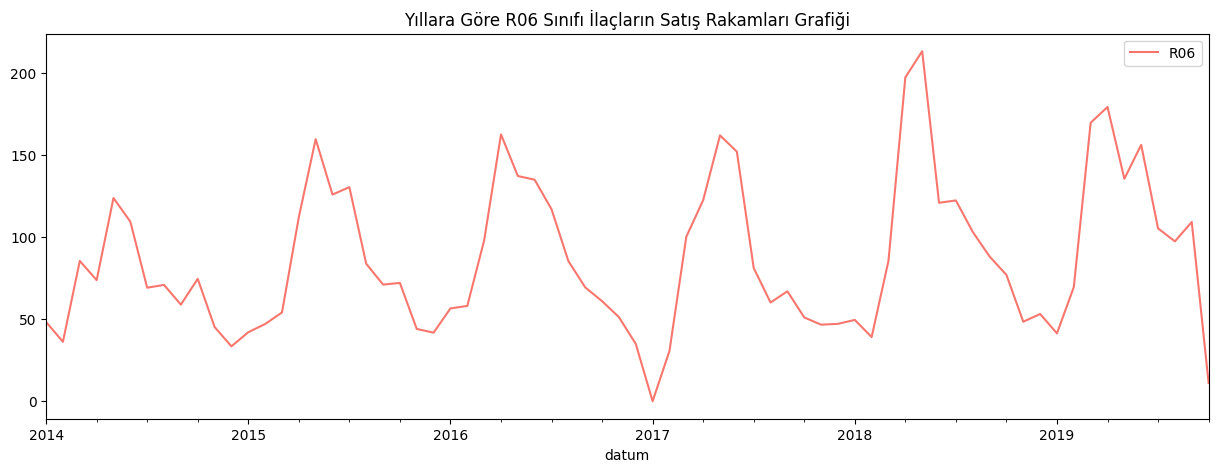

In [136]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='-', figsize=(15,5), color=color_pal[0], title='Yıllara Göre R06 Sınıfı İlaçların Satış Rakamları Grafiği')

In [137]:
split_date = '01-Jan-2019'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

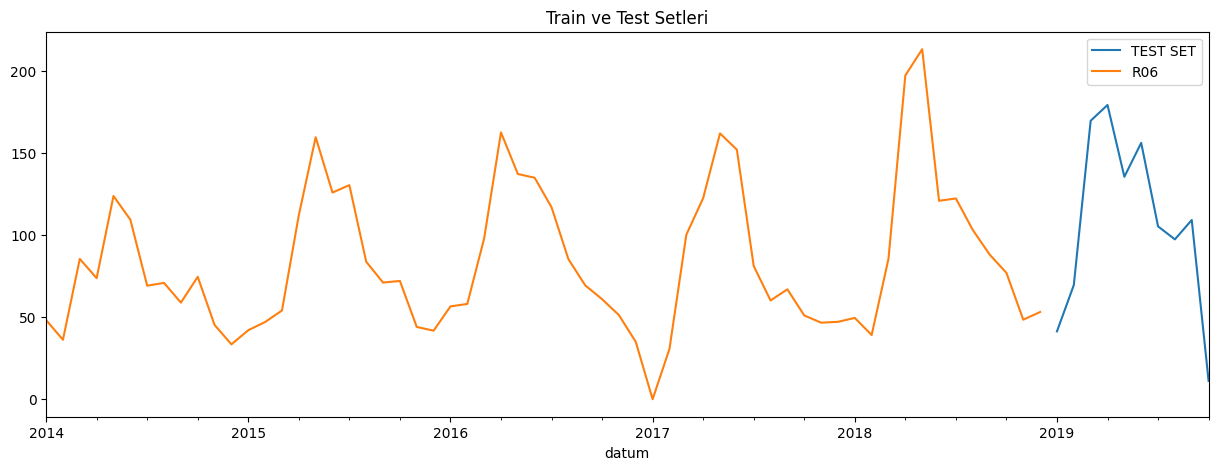

In [138]:
_ = df_test \
    .rename(columns={'R06': 'TEST SET'}) \
    .join(df_train.rename(columns={'R03': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Train ve Test Setleri', style='-')

In [139]:
X_train, y_train = create_features(df_train, label='R06')
X_test, y_test = create_features(df_test, label='R06')

In [140]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

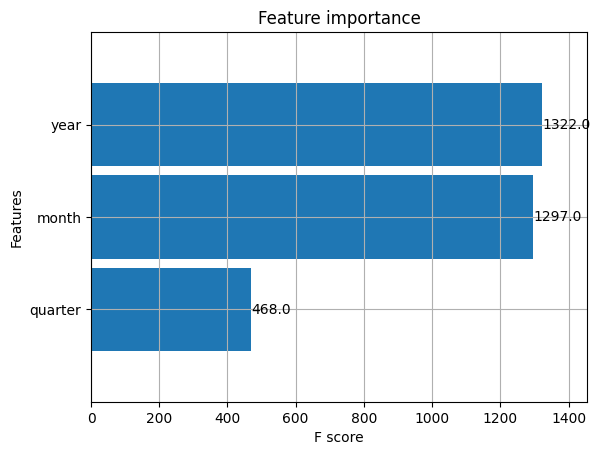

In [141]:
_ = plot_importance(reg, height=0.9)

In [142]:
df_test['R06_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

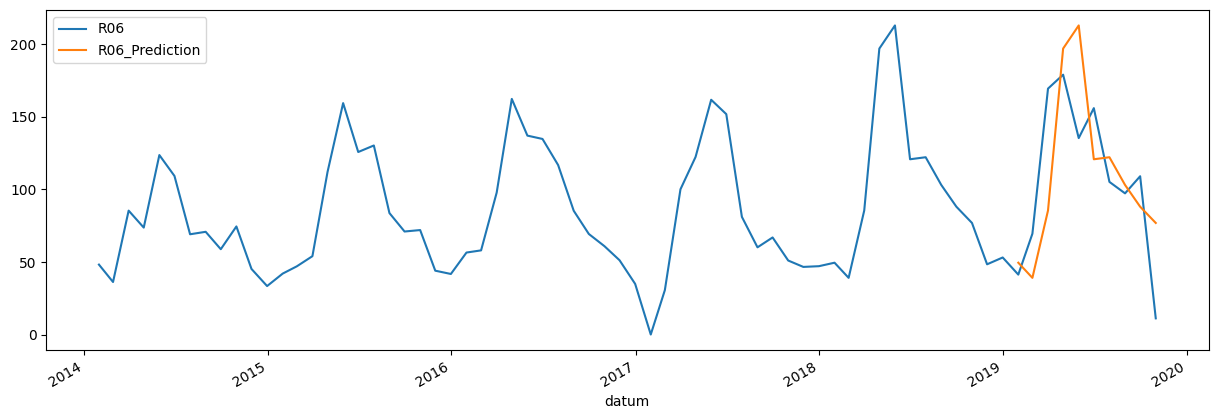

In [143]:
_ = df_all[['R06','R06_Prediction']].plot(figsize=(15, 5))

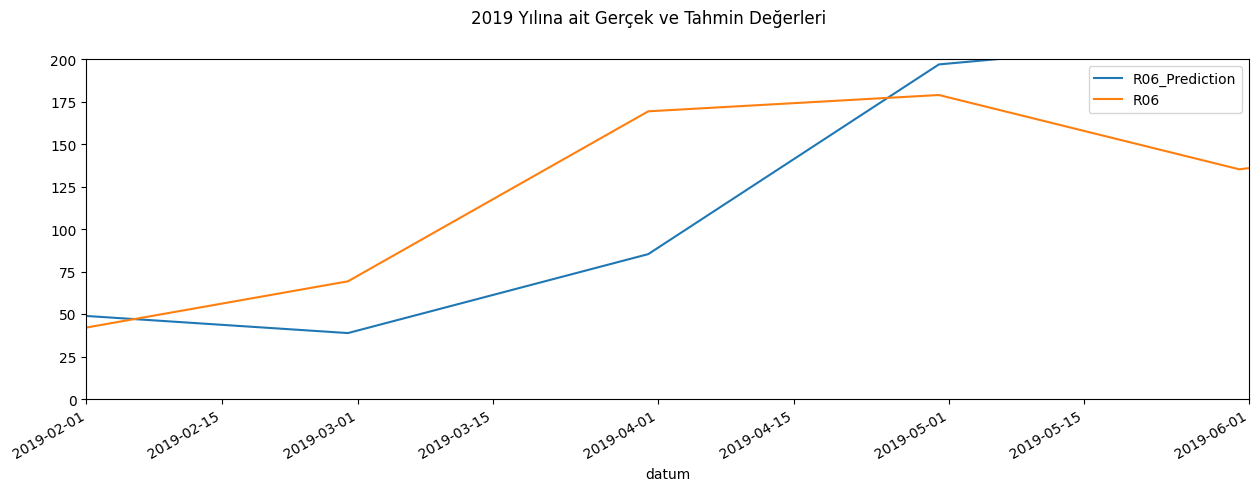

In [144]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['R06_Prediction','R06']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='02-01-2019', upper='06-01-2019')
ax.set_ylim(0, 200)
plot = plt.suptitle('2019 Yılına ait Gerçek ve Tahmin Değerleri')